In [1]:
import ast
from pathlib import Path

import folium
import humanize
import pandas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# U for Uber, T for T4c, O for OpenStreetMap
START_DAY = 1
END_DAY = 21  # incl.
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")
OBASEPATH = Path("/iarai/public/t4c/osm")

CITY = "barcelona"
YEAR = 2020
MONTH = 2


# 2020-02-01 Sat
# 2020-02-02 Sun
# 2020-02-03 Mon
# 2020-02-04 Tue
# 2020-02-05 Wed
# 2020-02-06 Thu
# 2020-02-07 Fri

DAYTIME_START_HOUR = 8
DAYTIME_END_HOUR = 18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
    "living_street",
    "service",
    "cycleway",
    "road",
    "construction",
]

In [3]:
plt.rcParams["axes.labelsize"] = 32
plt.rcParams['legend.title_fontsize'] = 28
plt.rcParams['legend.fontsize'] = 24

In [4]:
# simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']
simplified_filter = lambda hw: hw in [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]

In [5]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

## Load Uber segment speeds daytime and within bounding box

In [6]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f"movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet")
uspeeds_df = uspeeds_df[(uspeeds_df["day"] >= START_DAY) & (uspeeds_df["day"] <= END_DAY)]
# uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
0,2020,2,18,21,2020-02-18T20:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,42.992,15.530,30238017_30246860_237659851
1,2020,2,11,20,2020-02-11T19:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,43.418,17.464,30238017_30246860_237659851
2,2020,2,16,15,2020-02-16T14:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,45.918,19.958,30238017_30246860_237659851
3,2020,2,16,22,2020-02-16T21:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,40.526,24.419,30238017_30246860_237659851
4,2020,2,20,21,2020-02-20T20:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,30.575,13.414,30238017_30246860_237659851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74268,2020,2,16,16,2020-02-16T15:00:00.000Z,8c48ec71ed1df701458ad59510e198bc7233825b,9baf980625f0f0ebc8843f5320367db9a8cb8b1a,be68c37f4d777f9d7fb81d84a519ead45783a795,546607926,3134509191,797407467,29.769,15.495,3134509191_797407467_546607926
74269,2020,2,11,21,2020-02-11T20:00:00.000Z,8c48ec71ed1df701458ad59510e198bc7233825b,9baf980625f0f0ebc8843f5320367db9a8cb8b1a,be68c37f4d777f9d7fb81d84a519ead45783a795,546607926,3134509191,797407467,20.946,5.343,3134509191_797407467_546607926
74270,2020,2,21,21,2020-02-21T20:00:00.000Z,8c48ec71ed1df701458ad59510e198bc7233825b,9baf980625f0f0ebc8843f5320367db9a8cb8b1a,be68c37f4d777f9d7fb81d84a519ead45783a795,546607926,3134509191,797407467,29.160,5.030,3134509191_797407467_546607926
74271,2020,2,4,21,2020-02-04T20:00:00.000Z,60e2cd8549b53a80e03e08ba30bb884afb72891d,864b9b2a76f790661736a07753e07eb97ffd1c8b,ddc8760fdddd4f0e3f6102c212ec012f3c358823,127005742,307752466,307752470,34.715,6.384,307752466_307752470_127005742


## Load our segment speeds and aggregate by hour

In [7]:
tspeeds_l = []
for i in range(START_DAY, END_DAY + 1):
    f = TBASEPATH / "speed_classes" / CITY / f"speed_classes_{YEAR}-{MONTH:02d}-{i:02d}.parquet"
    print(f)
    df = pd.read_parquet(f)
    # ['u', 'v', 'gkey', 'osmid', 'day', 't', 'volume_class', 'volume','median_speed_kph', 'mean_speed_kph', 'std_speed_kph', 'free_flow_kph'],
    #     print(df.columns)
    df["date"] = df["day"]
    df["year"] = YEAR
    df["month"] = MONTH
    df["day"] = i
    df["hour"] = df["t"] // 4
    df = (
        df[["u", "v", "gkey", "year", "month", "day", "hour", "volume", "volume_class", "median_speed_kph", "free_flow_kph", "std_speed_kph"]]
        .groupby(by=["u", "v", "gkey", "year", "month", "day", "hour"])
        .agg(
            volume_class=("volume_class", "mean"),
            volume=("volume", "mean"),
            std_speed_kph=("std_speed_kph", "mean"),
            median_speed_kph=("median_speed_kph", "mean"),
            free_flow_kph=("free_flow_kph", "first"),
        )
        .reset_index()
    )
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
# tspeeds_df = tspeeds_df.rename(columns={'osmid': 'osm_way_id'})
tspeeds_df

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-01.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-02.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-03.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-04.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-05.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-06.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-07.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/barcelona/speed_classes_2020-02-08.parquet
/iarai/public/t4c/data_pipeline/release20221028_

,u,v,gkey,year,month,day,hour,volume_class,volume,std_speed_kph,median_speed_kph,free_flow_kph
0,21638861,21638859,21638861_21638859_291731095,2020,2,1,8,1.0,1.000000,0.000000,29.647059,35.294118
1,21638861,21638859,21638861_21638859_291731095,2020,2,1,11,3.0,4.500000,3.091828,45.176471,35.294118
2,21638861,21638859,21638861_21638859_291731095,2020,2,1,12,5.0,5.000000,9.176471,31.764706,35.294118
3,21638861,21638859,21638861_21638859_291731095,2020,2,1,15,5.0,12.500000,0.000000,1.411765,35.294118
4,21638861,21638859,21638861_21638859_291731095,2020,2,1,16,5.0,8.333333,0.000000,0.627451,35.294118
...,...,...,...,...,...,...,...,...,...,...,...,...
65036,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,10,2.0,2.500000,0.000000,24.000000,33.647059
65037,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,11,4.0,4.000000,0.000000,25.176471,33.647059
65038,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,12,1.0,1.000000,0.000000,35.764706,33.647059
65039,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,14,5.0,10.000000,0.000000,26.823529,33.647059


In [8]:
u_ids = set(zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["gkey"]))
u_ids

{(769906814, 4472629999, '769906814_4472629999_62071238'),
 (5240293879, 318794598, '5240293879_318794598_541985951'),
 (668523613, 4826156653, '668523613_4826156653_114573197'),
 (415991032, 448197587, '415991032_448197587_554109744'),
 (426884331, 30556734, '426884331_30556734_123630159'),
 (4538123437, 30248342, '4538123437_30248342_261716934'),
 (1479334626, 30685337, '1479334626_30685337_422439067'),
 (3218700062, 3218698756, '3218700062_3218698756_8380873'),
 (3053342334, 442540243, '3053342334_442540243_226319969'),
 (2689511766, 4469079935, '2689511766_4469079935_449991647'),
 (955374297, 4050910350, '955374297_4050910350_569040509'),
 (1311619324, 1311619497, '1311619324_1311619497_271470040'),
 (30295304, 125930808, '30295304_125930808_307718503'),
 (5274125911, 3768786069, '5274125911_3768786069_545724435'),
 (216349848, 211637737, '216349848_211637737_545937949'),
 (301860340, 301858779, '301860340_301858779_566431867'),
 (112426103, 1282870796, '112426103_1282870796_474494

In [9]:
t_ids = set(zip(tspeeds_df["u"], tspeeds_df["v"], tspeeds_df["gkey"]))
t_ids

{(769906814, 4472629999, '769906814_4472629999_62071238'),
 (5240293879, 318794598, '5240293879_318794598_541985951'),
 (668523613, 4826156653, '668523613_4826156653_114573197'),
 (415991032, 448197587, '415991032_448197587_554109744'),
 (426884331, 30556734, '426884331_30556734_123630159'),
 (4538123437, 30248342, '4538123437_30248342_261716934'),
 (307753457, 307753469, '307753457_307753469_105020769'),
 (1479334626, 30685337, '1479334626_30685337_422439067'),
 (3218700062, 3218698756, '3218700062_3218698756_8380873'),
 (2689511766, 4469079935, '2689511766_4469079935_449991647'),
 (3053342334, 442540243, '3053342334_442540243_226319969'),
 (955374297, 4050910350, '955374297_4050910350_569040509'),
 (256484320, 863733388, '256484320_863733388_23855624'),
 (1311619324, 1311619497, '1311619324_1311619497_271470040'),
 (30295304, 125930808, '30295304_125930808_307718503'),
 (5274125911, 3768786069, '5274125911_3768786069_545724435'),
 (216349848, 211637737, '216349848_211637737_545937949

In [10]:
# does not hold with the restricted time frame...
# assert t_ids.issubset(u_ids)

## Restrict to daytime only

In [11]:
tspeeds_df = tspeeds_df[(tspeeds_df["hour"] >= DAYTIME_START_HOUR) & (tspeeds_df["hour"] < DAYTIME_END_HOUR)]
tspeeds_df

,u,v,gkey,year,month,day,hour,volume_class,volume,std_speed_kph,median_speed_kph,free_flow_kph
0,21638861,21638859,21638861_21638859_291731095,2020,2,1,8,1.0,1.000000,0.000000,29.647059,35.294118
1,21638861,21638859,21638861_21638859_291731095,2020,2,1,11,3.0,4.500000,3.091828,45.176471,35.294118
2,21638861,21638859,21638861_21638859_291731095,2020,2,1,12,5.0,5.000000,9.176471,31.764706,35.294118
3,21638861,21638859,21638861_21638859_291731095,2020,2,1,15,5.0,12.500000,0.000000,1.411765,35.294118
4,21638861,21638859,21638861_21638859_291731095,2020,2,1,16,5.0,8.333333,0.000000,0.627451,35.294118
...,...,...,...,...,...,...,...,...,...,...,...,...
65036,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,10,2.0,2.500000,0.000000,24.000000,33.647059
65037,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,11,4.0,4.000000,0.000000,25.176471,33.647059
65038,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,12,1.0,1.000000,0.000000,35.764706,33.647059
65039,6502276600,3679449104,6502276600_3679449104_695674740,2020,2,21,14,5.0,10.000000,0.000000,26.823529,33.647059


In [12]:
uspeeds_df = uspeeds_df[(uspeeds_df["hour"] >= DAYTIME_START_HOUR) & (uspeeds_df["hour"] < DAYTIME_END_HOUR)]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
2,2020,2,16,15,2020-02-16T14:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,45.918,19.958,30238017_30246860_237659851
37,2020,2,12,14,2020-02-12T13:00:00.000Z,1ca22b2e85dc758dfaf19a634a3464291558e775,0cc79609af44fcf6c64c24cb311f778c5b84efb1,f0fd52a2c46c636d56e953c6a9b2c4c791c95645,237725939,126798008,1311833061,23.724,16.625,126798008_1311833061_237725939
46,2020,2,16,14,2020-02-16T13:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,1390694013,32.268,7.572,1390694381_1390694013_561549331
50,2020,2,16,15,2020-02-16T14:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,1390694013,34.399,7.176,1390694381_1390694013_561549331
55,2020,2,1,13,2020-02-01T12:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,1390694013,29.510,6.231,1390694381_1390694013_561549331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74238,2020,2,17,13,2020-02-17T12:00:00.000Z,e23baa4202f21f1ce0f397512a14cd9200f0105b,c812c776edbe4eef411f73956d9ac9c348dea5d9,0f21ac5f044851b234c50e5eead2b00e2c51b38a,35167923,60969458,60969471,23.745,4.404,60969458_60969471_35167923
74248,2020,2,16,14,2020-02-16T13:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,4793246800,44.847,16.372,301572821_4793246800_140001496
74249,2020,2,13,14,2020-02-13T13:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,4793246800,39.412,12.429,301572821_4793246800_140001496
74260,2020,2,16,15,2020-02-16T14:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,4793246800,28.581,22.482,301572821_4793246800_140001496


## Merge with road graph in bounding box

In [13]:
df_edges = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,21638861_21638859_291731095,21638861,21638859,291731095,50.0,50,residential,,,,198.710412,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x99\xaa...,Passeig de Joan de Borbó
1,21638872_4229056910_291731094,21638872,4229056910,291731094,50.0,50,tertiary,,,,83.740778,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00a\xcf\x8...,Passeig de Joan de Borbó
2,21638874_21638872_291731094,21638874,21638872,291731094,50.0,50,tertiary,,,,187.993767,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00=\xb5\x9...,Passeig de Joan de Borbó
3,21638886_2952200683_237790232,21638886,2952200683,237790232,50.0,50,tertiary,,,,80.120100,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00C.\x82\x...,Passeig de Joan de Borbó
4,21638891_533663031_18512190,21638891,533663031,18512190,50.0,50,tertiary,,,,177.556771,b'\x01\x02\x00\x00\x00\x06\x00\x00\x00<\x08K\x...,Passeig d'Isabel II
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,6485217417_380722287_576957404,6485217417,380722287,576957404,50.0,50,tertiary,,,,60.841548,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00=\x02\xc...,Carretera de Barcelona a Puigcerdá
5939,6485217427_425763064_36005986,6485217427,425763064,36005986,50.0,50,tertiary,,,,31.372892,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdc\x89...,Carrer Pla de Matabous
5940,6486942738_434451638_37286986,6486942738,434451638,37286986,50.0,50,tertiary,,,,430.706510,b'\x01\x02\x00\x00\x00\x0c\x00\x00\x00\xba\xba...,pont del Molinet
5941,6487028700_412453967_662919197,6487028700,412453967,662919197,50.0,50,secondary,,,,177.087661,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x86 \x0...,Avinguda de Vallcarca


In [14]:
df_nodes = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
df_nodes

,node_id,x,y,geometry
0,21638859,2.188693,41.376347,b'\x01\x01\x00\x00\x00\xb4\xc4o\xafq\x82\x01@\...
1,21638861,2.188040,41.378011,b'\x01\x01\x00\x00\x00\x99\xaaj8\x1b\x81\x01@\...
2,21638872,2.187738,41.378797,b'\x01\x01\x00\x00\x00a\xcf\x8d\x9f|\x80\x01@\...
3,21638874,2.187119,41.380371,b'\x01\x01\x00\x00\x00=\xb5\x9f18\x7f\x01@\x8e...
4,21638886,2.185963,41.381278,b'\x01\x01\x00\x00\x00C.\x82\x10\xda|\x01@U\x9...
...,...,...,...,...
5525,6485217427,2.185904,41.500209,b'\x01\x01\x00\x00\x00\xdc\x89\xedI\xbb|\x01@\...
5526,6485528262,2.030090,41.335952,b'\x01\x01\x00\x00\x00\x8aw\xdb\xe0\x9f=\x00@e...
5527,6486942738,2.208156,41.434742,"b'\x01\x01\x00\x00\x00\xba\xbac\xb1M\xaa\x01@""..."
5528,6487028700,2.142968,41.413227,b'\x01\x01\x00\x00\x00\x86 \x07%\xcc$\x01@\xd2...


In [15]:
df_edges = df_edges.merge(df_nodes, left_on="u", right_on="node_id", suffixes=["", "_u"]).merge(df_nodes, left_on="v", right_on="node_id", suffixes=["", "_v"])
df_edges.rename(columns={"x": "x_u", "y": "y_u"}, inplace=True)
del df_edges["geometry_u"]
del df_edges["geometry_v"]
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v
0,21638861_21638859_291731095,21638861,21638859,291731095,50.0,50,residential,,,,198.710412,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x99\xaa...,Passeig de Joan de Borbó,21638861,2.188040,41.378011,21638859,2.188693,41.376347
1,21638872_4229056910_291731094,21638872,4229056910,291731094,50.0,50,tertiary,,,,83.740778,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00a\xcf\x8...,Passeig de Joan de Borbó,21638872,2.187738,41.378797,4229056910,2.188009,41.378093
2,21638874_21638872_291731094,21638874,21638872,291731094,50.0,50,tertiary,,,,187.993767,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00=\xb5\x9...,Passeig de Joan de Borbó,21638874,2.187119,41.380371,21638872,2.187738,41.378797
3,21638886_2952200683_237790232,21638886,2952200683,237790232,50.0,50,tertiary,,,,80.120100,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00C.\x82\x...,Passeig de Joan de Borbó,21638886,2.185963,41.381278,2952200683,2.186608,41.380957
4,21638891_533663031_18512190,21638891,533663031,18512190,50.0,50,tertiary,,,,177.556771,b'\x01\x02\x00\x00\x00\x06\x00\x00\x00<\x08K\x...,Passeig d'Isabel II,21638891,2.183192,41.382603,533663031,2.182166,41.381379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,6485217417_380722287_576957404,6485217417,380722287,576957404,50.0,50,tertiary,,,,60.841548,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00=\x02\xc...,Carretera de Barcelona a Puigcerdá,6485217417,2.186074,41.500567,380722287,2.186331,41.501051
5939,6485217427_425763064_36005986,6485217427,425763064,36005986,50.0,50,tertiary,,,,31.372892,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdc\x89...,Carrer Pla de Matabous,6485217427,2.185904,41.500209,425763064,2.186021,41.500466
5940,6486942738_434451638_37286986,6486942738,434451638,37286986,50.0,50,tertiary,,,,430.706510,b'\x01\x02\x00\x00\x00\x0c\x00\x00\x00\xba\xba...,pont del Molinet,6486942738,2.208156,41.434742,434451638,2.211516,41.436670
5941,6487028700_412453967_662919197,6487028700,412453967,662919197,50.0,50,secondary,,,,177.087661,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x86 \x0...,Avinguda de Vallcarca,6487028700,2.142968,41.413227,412453967,2.142776,41.414809


In [16]:
def in_bb(x, y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

In [17]:
# Barcelona
y_min, y_max, x_min, x_max = 41.25300, 41.74800, 1.92500, 2.36100

In [18]:
df_edges["in_bb"] = [(in_bb(x_u, y_u) or in_bb(x_v, y_v)) for x_u, y_u, x_v, y_v in zip(df_edges["x_u"], df_edges["y_u"], df_edges["x_v"], df_edges["y_v"])]

In [19]:
df_edges = df_edges[df_edges["in_bb"] == True]
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,21638861_21638859_291731095,21638861,21638859,291731095,50.0,50,residential,,,,198.710412,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x99\xaa...,Passeig de Joan de Borbó,21638861,2.188040,41.378011,21638859,2.188693,41.376347,True
1,21638872_4229056910_291731094,21638872,4229056910,291731094,50.0,50,tertiary,,,,83.740778,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00a\xcf\x8...,Passeig de Joan de Borbó,21638872,2.187738,41.378797,4229056910,2.188009,41.378093,True
2,21638874_21638872_291731094,21638874,21638872,291731094,50.0,50,tertiary,,,,187.993767,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00=\xb5\x9...,Passeig de Joan de Borbó,21638874,2.187119,41.380371,21638872,2.187738,41.378797,True
3,21638886_2952200683_237790232,21638886,2952200683,237790232,50.0,50,tertiary,,,,80.120100,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00C.\x82\x...,Passeig de Joan de Borbó,21638886,2.185963,41.381278,2952200683,2.186608,41.380957,True
4,21638891_533663031_18512190,21638891,533663031,18512190,50.0,50,tertiary,,,,177.556771,b'\x01\x02\x00\x00\x00\x06\x00\x00\x00<\x08K\x...,Passeig d'Isabel II,21638891,2.183192,41.382603,533663031,2.182166,41.381379,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,6485217417_380722287_576957404,6485217417,380722287,576957404,50.0,50,tertiary,,,,60.841548,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00=\x02\xc...,Carretera de Barcelona a Puigcerdá,6485217417,2.186074,41.500567,380722287,2.186331,41.501051,True
5939,6485217427_425763064_36005986,6485217427,425763064,36005986,50.0,50,tertiary,,,,31.372892,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdc\x89...,Carrer Pla de Matabous,6485217427,2.185904,41.500209,425763064,2.186021,41.500466,True
5940,6486942738_434451638_37286986,6486942738,434451638,37286986,50.0,50,tertiary,,,,430.706510,b'\x01\x02\x00\x00\x00\x0c\x00\x00\x00\xba\xba...,pont del Molinet,6486942738,2.208156,41.434742,434451638,2.211516,41.436670,True
5941,6487028700_412453967_662919197,6487028700,412453967,662919197,50.0,50,secondary,,,,177.087661,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x86 \x0...,Avinguda de Vallcarca,6487028700,2.142968,41.413227,412453967,2.142776,41.414809,True


In [20]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=["u", "v", "gkey", "year", "month", "day", "hour"]).merge(df_edges, on=["u", "v", "gkey"])
ut_merged

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,2020,2,16,15,2020-02-16T14:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,...,149.211483,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xbc\xad...,Carrer d'Entença,30238017,2.145985,41.383100,30246860,2.144917,41.383913,True
1,2020,2,12,14,2020-02-12T13:00:00.000Z,1ca22b2e85dc758dfaf19a634a3464291558e775,0cc79609af44fcf6c64c24cb311f778c5b84efb1,f0fd52a2c46c636d56e953c6a9b2c4c791c95645,237725939,126798008,...,5.181140,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xe2\xbc...,Passeig de Lluís Companys,126798008,2.180533,41.391578,1311833061,2.180571,41.391604,True
2,2020,2,16,15,2020-02-16T14:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00)1\xbe\x...,,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
3,2020,2,1,13,2020-02-01T12:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00)1\xbe\x...,,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
4,2020,2,7,14,2020-02-07T13:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00)1\xbe\x...,,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,2020,2,21,13,2020-02-21T12:00:00.000Z,ec134bb2d0215e3b2af827c1db0bdae026975ec0,13e470bb203b0e92b2a1fb484cffa1776439ee75,d526f5a65a31bea265c5d01eba91b36fb6d52ac1,207322868,413753006,...,134.004399,b'\x01\x02\x00\x00\x00\x07\x00\x00\x00}S\xfd\x...,Rambla del Fondo,413753006,2.219326,41.451724,413753826,2.220449,41.452161,True
5771,2020,2,16,14,2020-02-16T13:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,...,27.774142,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xe3\xf4...,Avinguda Diagonal (lateral mar),301572821,2.156911,41.395746,4793246800,2.157154,41.395808,True
5772,2020,2,13,14,2020-02-13T13:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,...,27.774142,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xe3\xf4...,Avinguda Diagonal (lateral mar),301572821,2.156911,41.395746,4793246800,2.157154,41.395808,True
5773,2020,2,16,15,2020-02-16T14:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,...,27.774142,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xe3\xf4...,Avinguda Diagonal (lateral mar),301572821,2.156911,41.395746,4793246800,2.157154,41.395808,True


## Matching rate

In [21]:
uspeeds_with_road_graph = uspeeds_df.merge(df_edges, on=["u", "v", "gkey"])
uspeeds_with_road_graph

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,2020,2,16,15,2020-02-16T14:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,...,149.211483,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xbc\xad...,Carrer d'Entença,30238017,2.145985,41.383100,30246860,2.144917,41.383913,True
1,2020,2,12,14,2020-02-12T13:00:00.000Z,1ca22b2e85dc758dfaf19a634a3464291558e775,0cc79609af44fcf6c64c24cb311f778c5b84efb1,f0fd52a2c46c636d56e953c6a9b2c4c791c95645,237725939,126798008,...,5.181140,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xe2\xbc...,Passeig de Lluís Companys,126798008,2.180533,41.391578,1311833061,2.180571,41.391604,True
2,2020,2,16,14,2020-02-16T13:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00)1\xbe\x...,,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
3,2020,2,16,15,2020-02-16T14:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00)1\xbe\x...,,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
4,2020,2,1,13,2020-02-01T12:00:00.000Z,104215d848d7e156d934d2cc233d7a5f7bf0e929,d50e192441bd05eb20b88b73e37bebc4bd40f685,d92f347d6d9541bb0f74867f7c29702fbbd993e2,561549331,1390694381,...,8.872127,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00)1\xbe\x...,,1390694381,2.068852,41.478437,1390694013,2.068775,41.478415,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9440,2020,2,17,13,2020-02-17T12:00:00.000Z,e23baa4202f21f1ce0f397512a14cd9200f0105b,c812c776edbe4eef411f73956d9ac9c348dea5d9,0f21ac5f044851b234c50e5eead2b00e2c51b38a,35167923,60969458,...,112.155747,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdd0\xc...,Carrer de Sant Marc,60969458,2.153650,41.401374,60969471,2.152798,41.400833,True
9441,2020,2,16,14,2020-02-16T13:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,...,27.774142,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xe3\xf4...,Avinguda Diagonal (lateral mar),301572821,2.156911,41.395746,4793246800,2.157154,41.395808,True
9442,2020,2,13,14,2020-02-13T13:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,...,27.774142,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xe3\xf4...,Avinguda Diagonal (lateral mar),301572821,2.156911,41.395746,4793246800,2.157154,41.395808,True
9443,2020,2,16,15,2020-02-16T14:00:00.000Z,f4650df872dbea0ffa7ad95402eef26ffabccbcc,1096869e74b5c75a8458837ac77ff4461980553f,0e858f9bf7c3ed7fb9ef86a96013708698635131,140001496,301572821,...,27.774142,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xe3\xf4...,Avinguda Diagonal (lateral mar),301572821,2.156911,41.395746,4793246800,2.157154,41.395808,True


In [22]:
humanize.metric(len(ut_merged))

'5.78 k'

In [23]:
len(ut_merged) / len(tspeeds_df)

0.008189177806548223

In [24]:
humanize.metric(len(tspeeds_df))

'705 k'

In [25]:
# road_graph is only within bb
len(uspeeds_with_road_graph) / len(uspeeds_df)

0.9927475299558546

In [26]:
humanize.metric(len(uspeeds_df))

'9.51 k'

In [27]:
len(ut_merged) / len(uspeeds_with_road_graph[uspeeds_with_road_graph["in_bb"] == True])

0.6114346214928533

In [28]:
len(tspeeds_df)

705199

In [29]:
len(uspeeds_with_road_graph)

9445

### Speed Differences

In [30]:
ut_merged.columns

Index(['year', 'month', 'day', 'hour', 'utc_timestamp', 'segment_id',
       'start_junction_id', 'end_junction_id', 'osmid_x', 'u', 'v',
       'speed_kph_mean', 'speed_kph_stddev', 'gkey', 'volume_class', 'volume',
       'std_speed_kph', 'median_speed_kph', 'free_flow_kph', 'osmid_y',
       'speed_kph', 'maxspeed', 'highway', 'oneway', 'lanes', 'tunnel',
       'length_meters', 'geometry', 'name', 'node_id', 'x_u', 'y_u',
       'node_id_v', 'x_v', 'y_v', 'in_bb'],
      dtype='object')

In [31]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"] - ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")
ut_merged

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,speed_diff,sort_key
1775,2020,2,17,14,2020-02-17T13:00:00.000Z,38fc6e1080097d9704bb92a98130889dba90f3fc,b06f742c90c802e7cb33edd98ab40a4605d22cef,67a2488a9fead140986a6762f4b6d70f4b556a39,31266893,347712637,...,,347712637,2.205381,41.394310,30253310,2.205874,41.394703,True,1.428660,3
2887,2020,2,21,15,2020-02-21T14:00:00.000Z,1d7d75bfb8a785d3db7b0d131f52fdd40aceb072,e711b8f00fddcf942d000b84b631996fa1035a08,b5ec74b6a87521b881ec6b867490bd7fc5563d07,542845438,5247963051,...,Carrer de Ramon Albó,5247963051,2.177356,41.424754,387127757,2.177319,41.425481,True,16.597235,4
1439,2020,2,20,13,2020-02-20T12:00:00.000Z,249e9713b3783f9ee300d8e6ca4576ef5ea085ad,5b7bfaa6fab333754c7d3ec600713790e923731e,3e59aaef249dd693d925493d54857fbb18f8ca51,238872782,622742067,...,avinguda d'Alfons XIII,622742067,2.226413,41.438154,3932683751,2.226581,41.438361,True,55.368745,4
4075,2020,2,21,14,2020-02-21T13:00:00.000Z,feecf37bdeef4cc9452938c1791f591d9fe65f3f,9e66b99c3b63d67c65476bde34865746fdb28ede,5417f774b16e3679f3a24a1b93ec771691d56aa8,237525159,26057307,...,Gran Via de les Corts Catalanes,26057307,2.164115,41.386310,71643529,2.165380,41.387231,True,-13.246588,4
4076,2020,2,16,15,2020-02-16T14:00:00.000Z,feecf37bdeef4cc9452938c1791f591d9fe65f3f,9e66b99c3b63d67c65476bde34865746fdb28ede,5417f774b16e3679f3a24a1b93ec771691d56aa8,237525159,26057307,...,Gran Via de les Corts Catalanes,26057307,2.164115,41.386310,71643529,2.165380,41.387231,True,8.531882,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,2020,2,20,13,2020-02-20T12:00:00.000Z,756f260f87994b4bd8ad065c2f836fc45815ff3b,3efe370949acf965e70928eb1f2e71afc9c3178a,db86427cda7be35738c4f10ecaf510880c77a951,674962061,1828115499,...,rambla de Sant Joan,1828115499,2.236875,41.448625,302192395,2.236348,41.448676,True,36.132412,11
3108,2020,2,20,13,2020-02-20T12:00:00.000Z,06c8131d725fd555f93df1cf960fd5c1bc697417,a9caac6a874ab04028352a8790469f38f4d18d01,1edf65ecb3154a24acfa63d0d0f46f77695a44ed,238179162,30242768,...,Carrer de Lepant,30242768,2.184898,41.398187,219018792,2.185957,41.397370,True,5.973000,11
2673,2020,2,16,15,2020-02-16T14:00:00.000Z,6941c7a6dd7a11d8034c988e57153e5cef2fbb9f,e08fecbc89e1b766dc14656fd8c4059935bf5b24,86e113e3e3822af69bc613fcd59204fa0e5f2f45,295281243,2989836095,...,Passeig de Gràcia,2989836095,2.161665,41.395022,3236553566,2.160894,41.395651,True,-4.403412,12
1363,2020,2,19,15,2020-02-19T14:00:00.000Z,2c05738a9d7d77e12cf914bd779fdafcce1eb9fc,147e3a445f5483c500086cf2d882f57c9aafe32e,c1acc1e2024ff01dbba73e8b8efadbeaeb12c94d,526568089,413753171,...,Carrer de Wagner,413753171,2.219852,41.450353,413753732,2.219340,41.449927,True,-8.729176,12


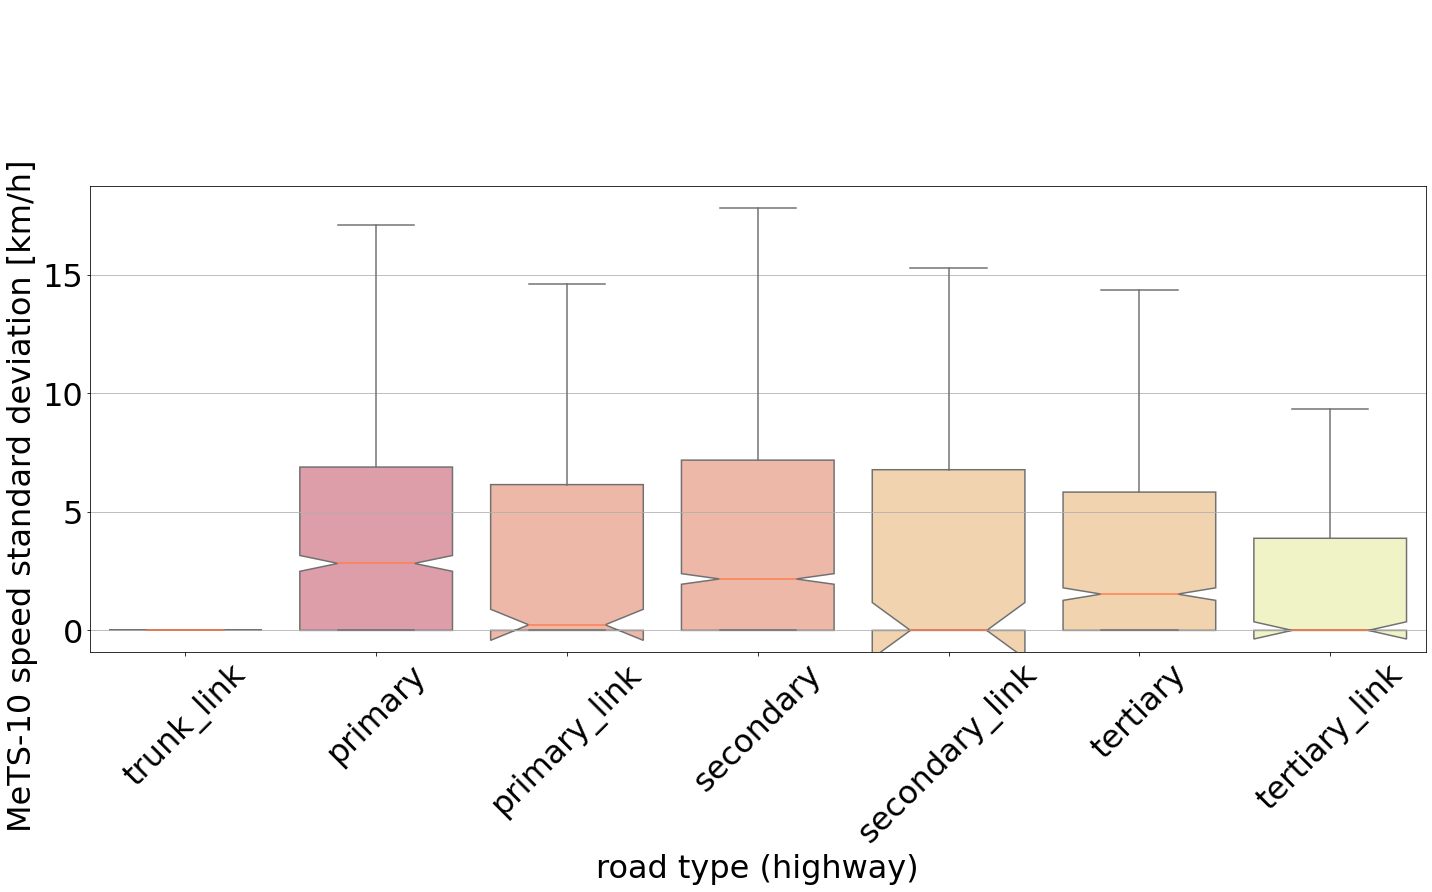

In [33]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="std_speed_kph",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='MeTS-10 speed standard deviation [km/h]               ')
#  t4c: higher stds in link classes than in the corresponding road class they link -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_std_speed_kph.pdf")

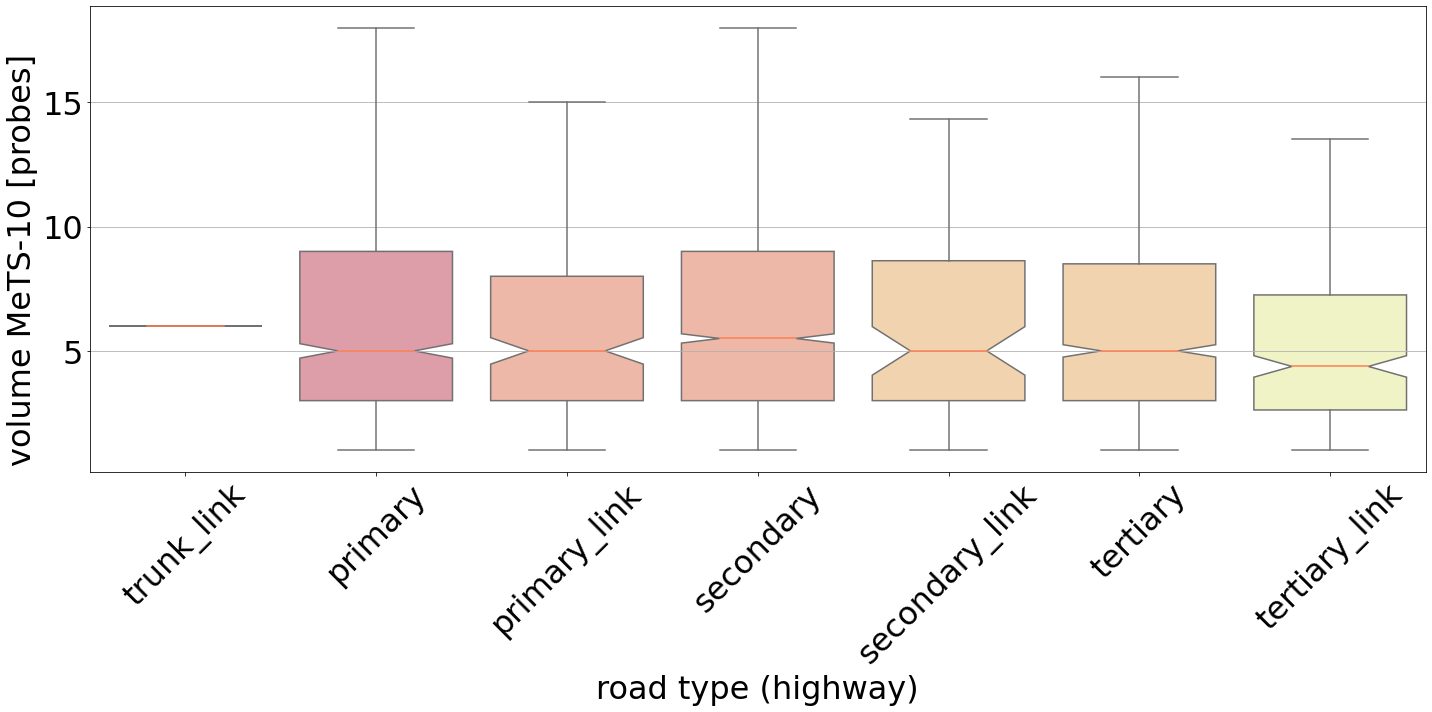

In [34]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="volume",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='volume MeTS-10 [probes]    ')
# t4c: higher volumes on links than on the class below -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_volume.pdf")

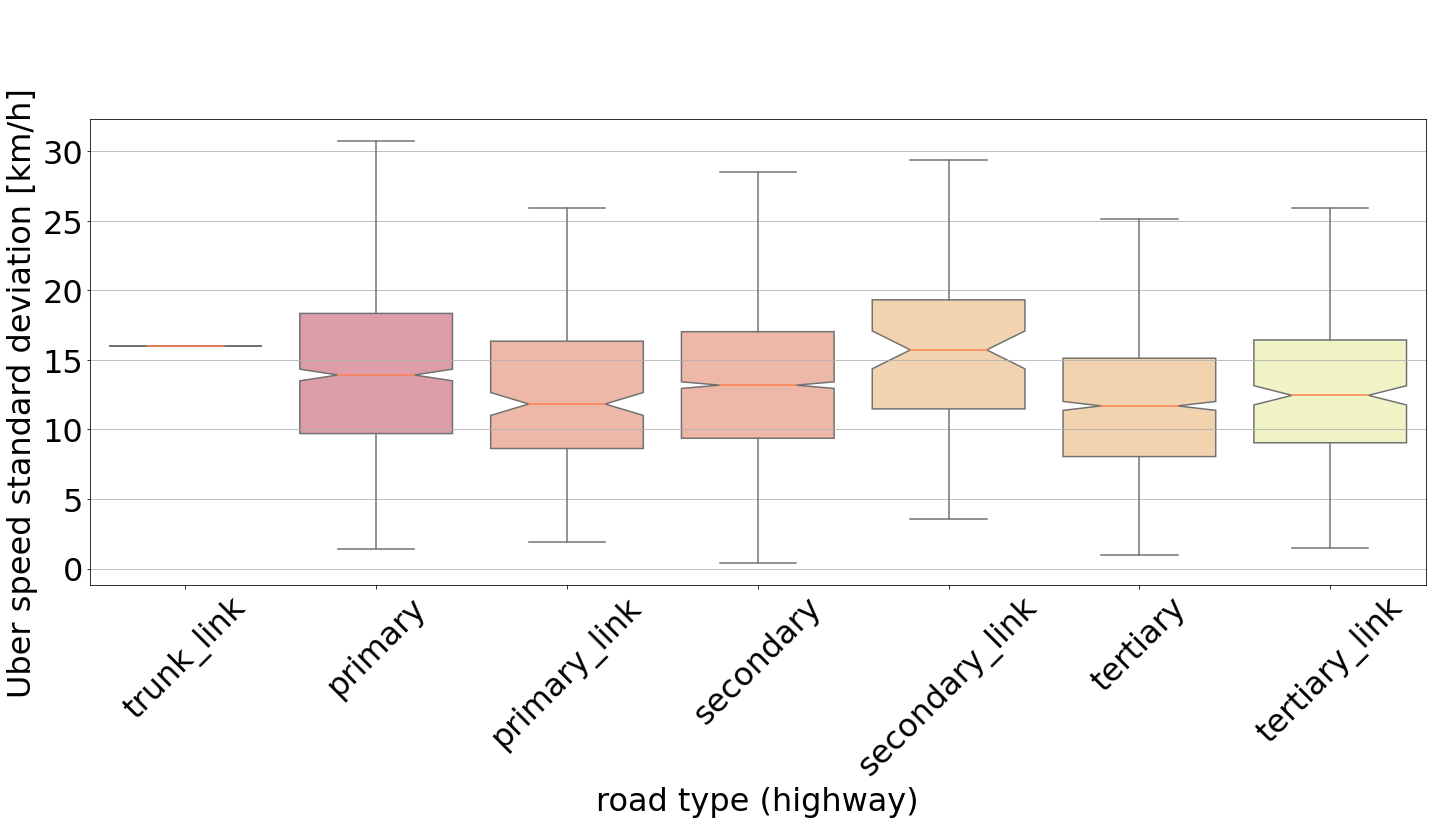

In [35]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_kph_stddev",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='Uber speed standard deviation [km/h]        ')

# Uber: link class have higher std than the class they link to (apart from motorway) -> acceleration/deceleration on links plausible
plt.savefig(f"{CITY.title()}_Uber_speed_mph_stddev.pdf")

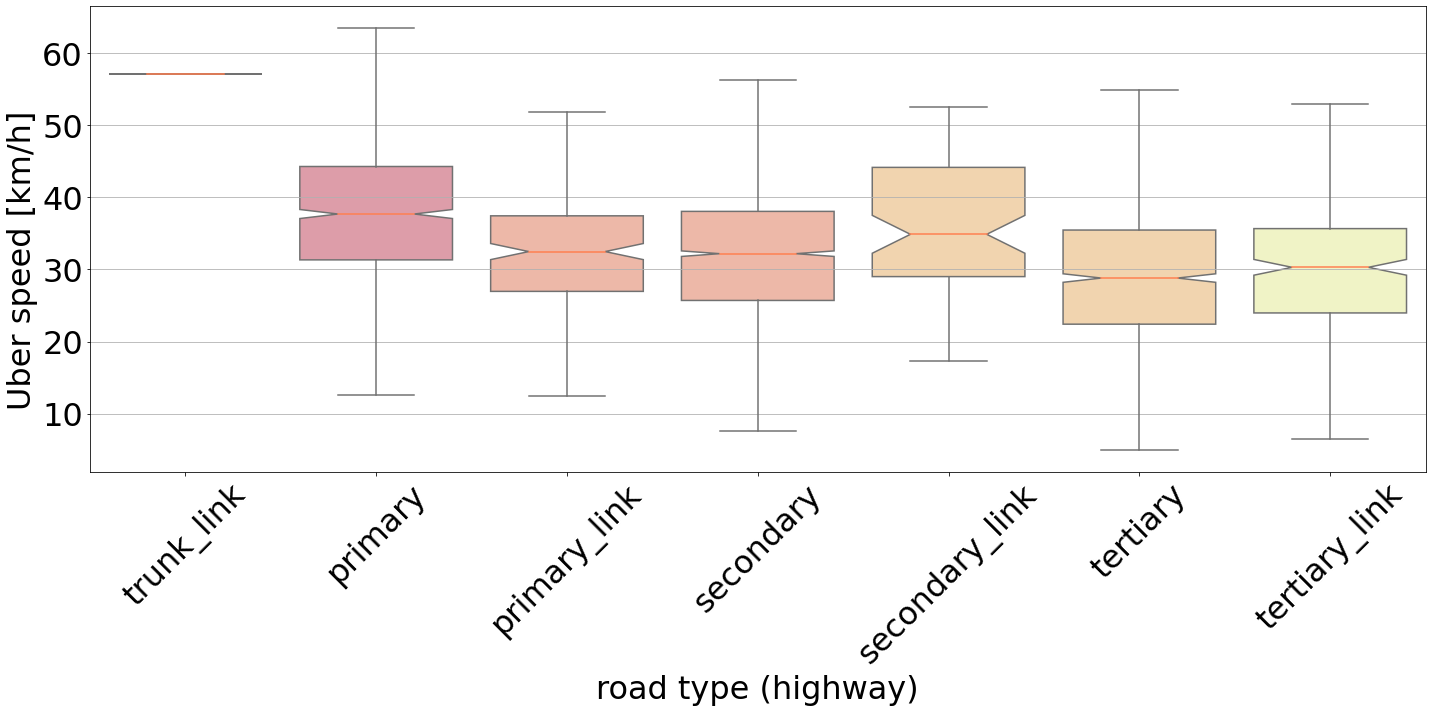

In [36]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_kph_mean",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='Uber speed [km/h]    ')
plt.savefig(f"{CITY.title()}_Uber_speed_kph_mean.pdf")

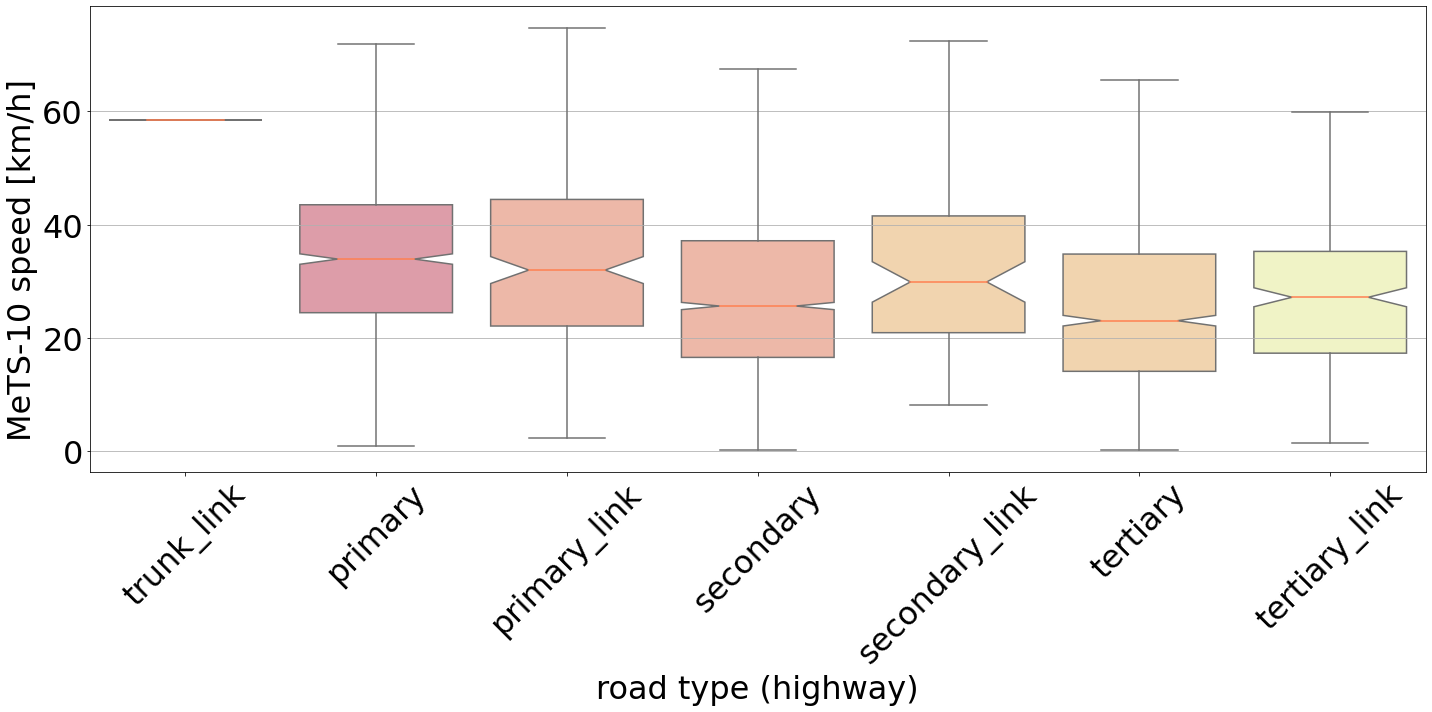

In [37]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="median_speed_kph",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='MeTS-10 speed [km/h]    ')
plt.savefig(f"{CITY.title()}_Uber_median_speed_kph.pdf")

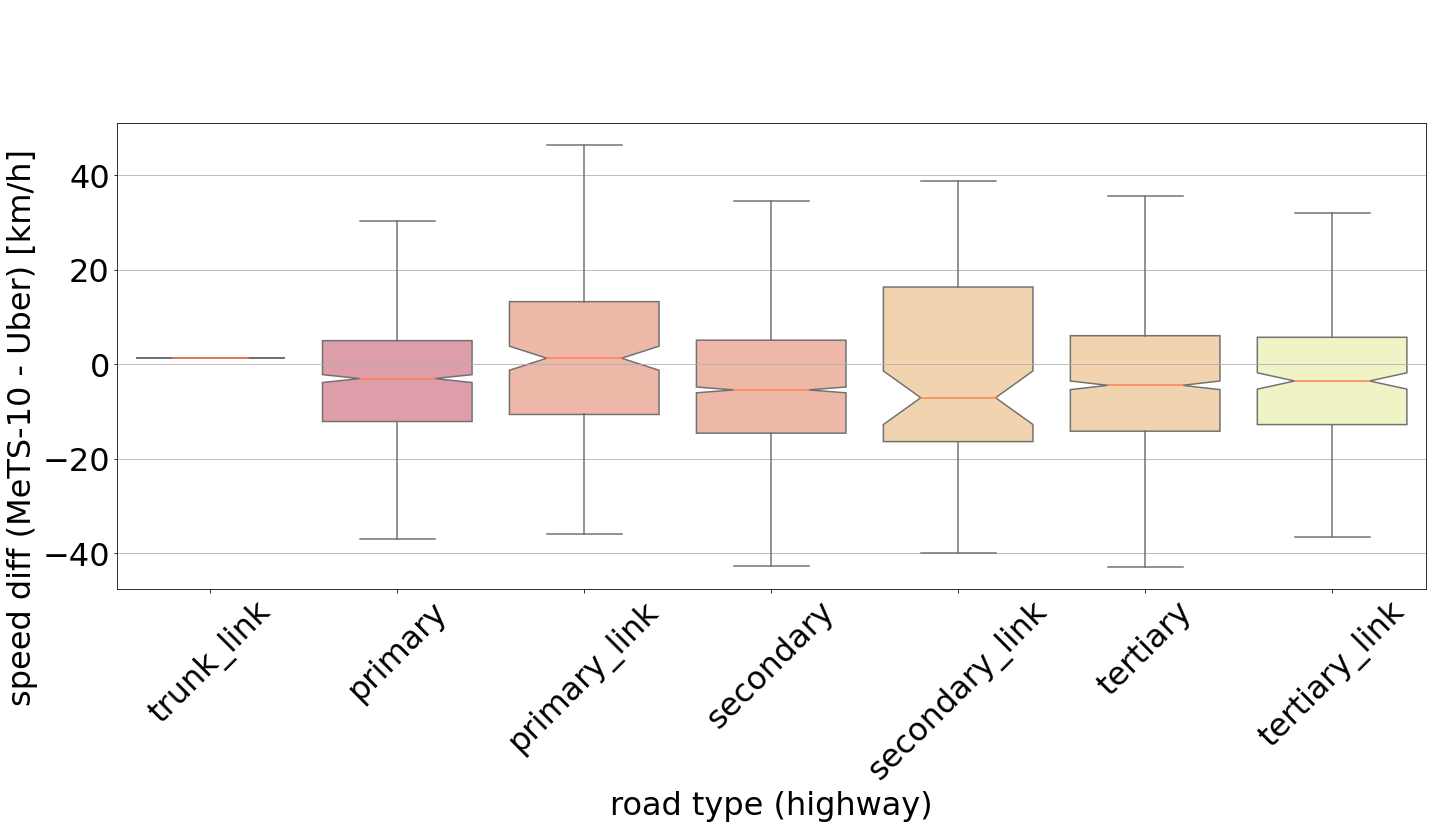

In [38]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_diff",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)

ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='speed diff (MeTS-10 - Uber) [km/h]              ')
plt.savefig(f"{CITY.title()}_Uber_speed_diff.pdf")

-
### TODO dayline samples Barcelona

In [39]:
def plot_dayline(u, v, day):
    fig, ax = plt.subplots(1, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)
    ax2 = ax.twinx()

    t_data = tspeeds_df[(tspeeds_df["u"] == u) & (tspeeds_df["v"] == v) & (tspeeds_df["day"] == day)].sort_values("hour")
    sns.lineplot(t_data, x="hour", y="median_speed_kph", ax=ax, color="orange")
    sns.lineplot(t_data, x="hour", y="volume", ax=ax, color="red")
    ax.errorbar(t_data["hour"], t_data["median_speed_kph"], yerr=t_data["std_speed_kph"], capsize=2, capthick=0.5, color="orange", linewidth=0.5, linestyle=":")

    u_data = uspeeds_df[(uspeeds_df["u"] == u) & (uspeeds_df["v"] == v) & (uspeeds_df["day"] == day)].sort_values("hour")
    sns.lineplot(u_data, x="hour", y="speed_kph_mean", ax=ax2, color="blue")
    ax.errorbar(u_data["hour"], u_data["speed_kph_mean"], yerr=u_data["speed_mph_stddev"], capsize=2, capthick=0.5, color="blue", linewidth=0.5, linestyle=":")
    rec = df_edges[(df_edges["u"] == u) & (df_edges["v"] == v)].iloc[0]
    [min([u_data["speed_kph_mean"].min(), t_data["median_speed_kph"].min()]), max([u_data["speed_kph_mean"].max(), t_data["median_speed_kph"].max()])]
    ax.set_ylim([0, 120])
    ax2.set_ylim([0, 120])
    #     print(rec)
    plt.title(f"{rec['name']}, {rec['highway']} {rec['length_meters']:.2f}m")

In [40]:
# plot_dayline(u = u, v = v, day=23)

## KDE

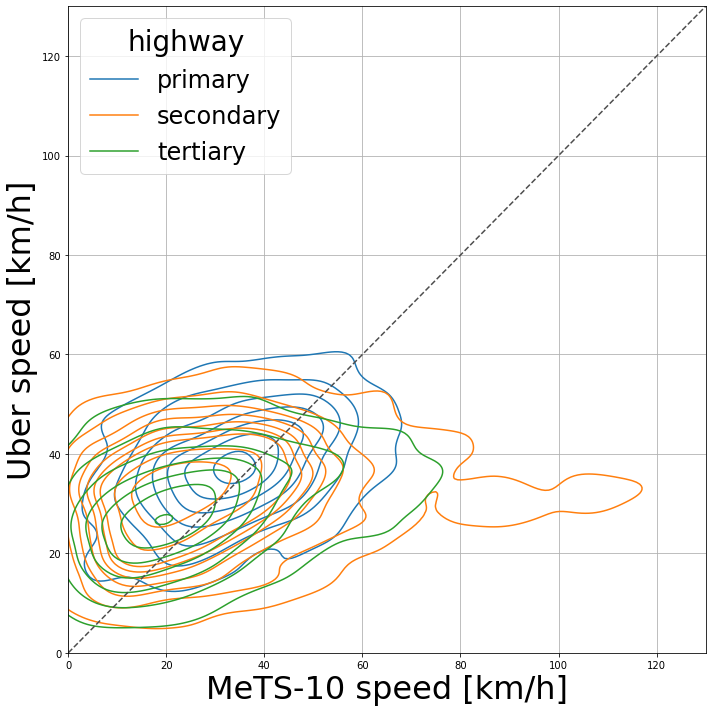

In [41]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.kdeplot(
    data=ut_merged[[simplified_filter(hw) and "link" not in hw for hw in ut_merged["highway"]]], x="median_speed_kph", y="speed_kph_mean", hue="highway", ax=ax
)
ax.plot([0, 130], [0, 130], ls="--", c=".3")
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid(axis="both")
ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_kde_highway_non_links.pdf")

/tmp/ipykernel_58976/3696829150.py:2: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


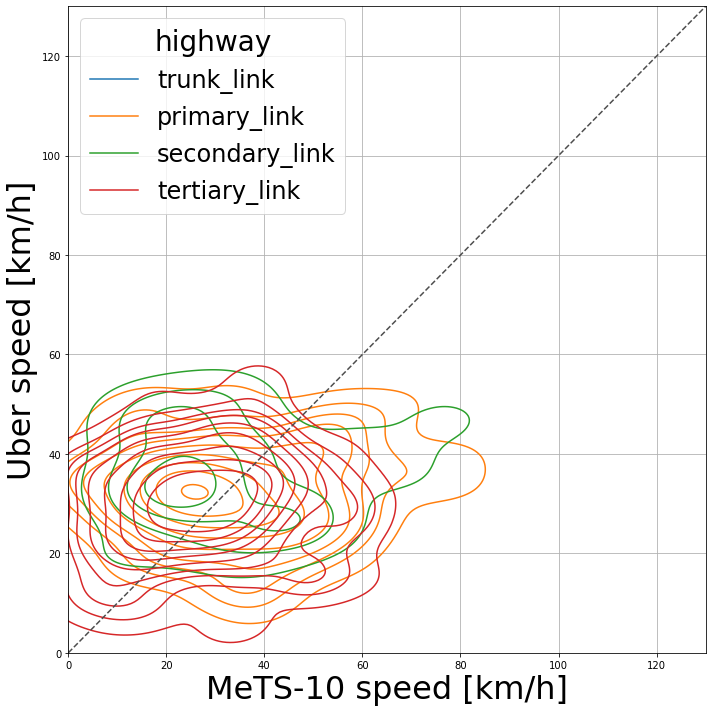

In [42]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.kdeplot(
    data=ut_merged[[simplified_filter(hw) and "link" in hw for hw in ut_merged["highway"]]], x="median_speed_kph", y="speed_kph_mean", hue="highway", ax=ax
)
ax.plot([0, 130], [0, 130], ls="--", c=".3")
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid(axis="both")
ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_kde_highway_links.pdf")

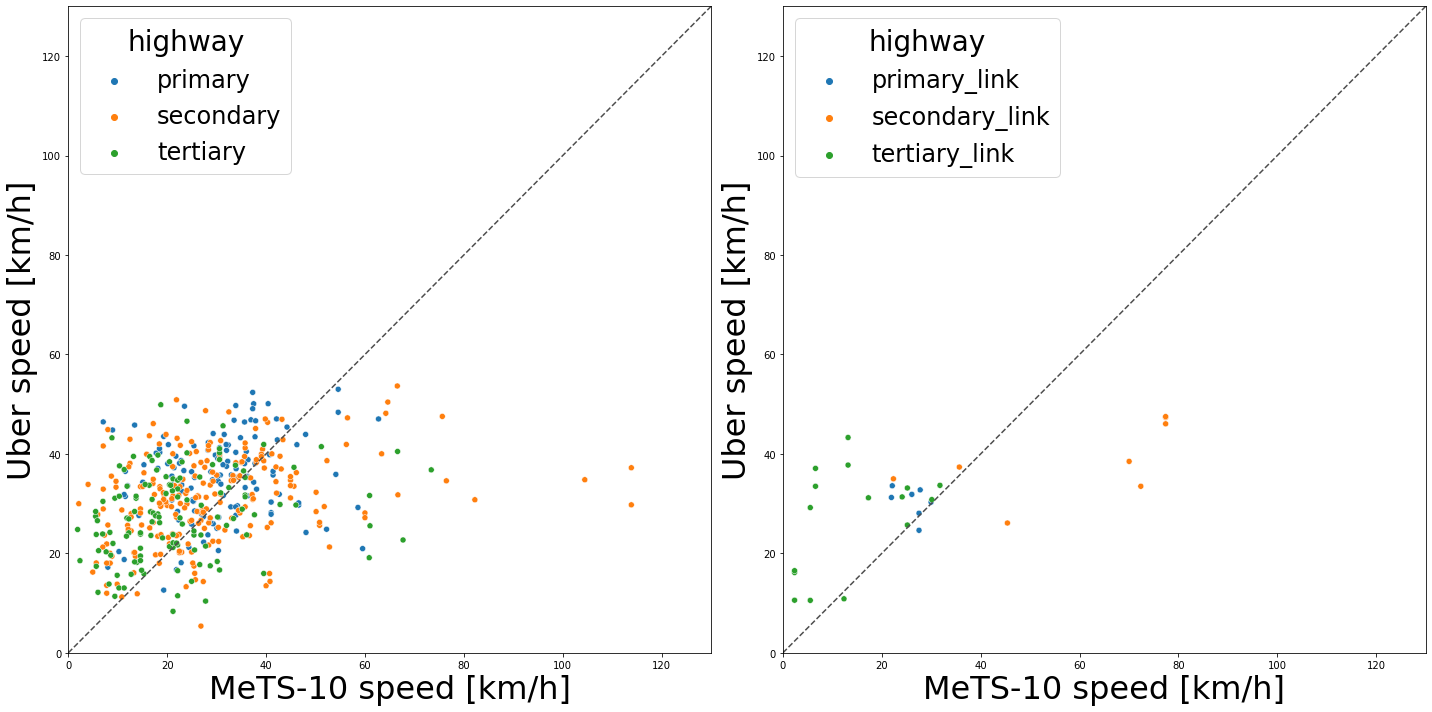

In [69]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
ax0, ax1 = axs
sns.scatterplot(
    data=ut_merged[[simplified_filter(hw) and "link" not in hw for hw in ut_merged["highway"]] & (ut_merged["day"] == END_DAY)],
    x="median_speed_kph",
    y="speed_kph_mean",
    hue="highway",
    ax=ax0,
)
sns.scatterplot(
    data=ut_merged[[simplified_filter(hw) and "link" in hw for hw in ut_merged["highway"]] & (ut_merged["day"] == END_DAY)],
    x="median_speed_kph",
    y="speed_kph_mean",
    hue="highway",
    ax=ax1,
)

for ax in axs:
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 130])
    ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_scatter_highway.png")

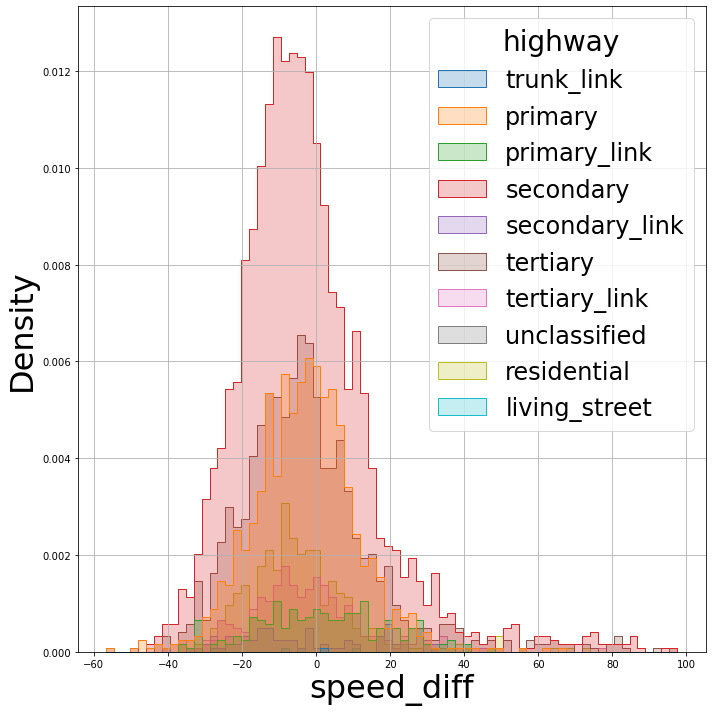

In [44]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.histplot(data=ut_merged, x="speed_diff", hue="highway", element="step", stat="density")
# ax.set_yscale('log')
ax.grid()
plt.savefig(f"{CITY.title()}_Uber_histogram_highway.pdf")

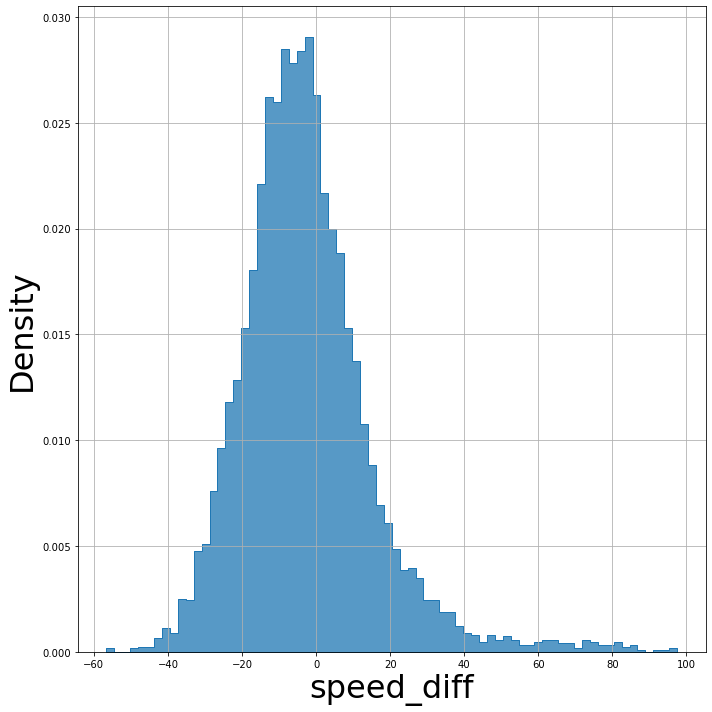

In [45]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.histplot(
    data=ut_merged,
    x="speed_diff"
    #              , hue="highway"
    ,
    element="step",
    stat="density",
)
# ax.set_yscale('log')
ax.grid()
plt.savefig(f"{CITY.title()}_Uber_histogram.pdf")

## Inspect extreme cases (speed_diff > 20)

In [46]:
df_cell_mapping = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_intersecting_cells.parquet")
df_cell_mapping

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,geometry_reversed,intersecting_cells
0,21638861_21638859_291731095,21638861,21638859,291731095,50.0,50,residential,,,,198.710412,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x99\xaa...,Passeig de Joan de Borbó,False,"[(369, 263, 2, 0.006904469070002202), (371, 26..."
1,21638872_4229056910_291731094,21638872,4229056910,291731094,50.0,50,tertiary,,,,83.740778,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00a\xcf\x8...,Passeig de Joan de Borbó,False,"[(369, 262, 2, 0.9682539682534146), (369, 263,..."
2,21638874_21638872_291731094,21638874,21638872,291731094,50.0,50,tertiary,,,,187.993767,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00=\xb5\x9...,Passeig de Joan de Borbó,False,"[(369, 262, 2, 0.1293922958192683), (367, 262,..."
3,21638886_2952200683_237790232,21638886,2952200683,237790232,50.0,50,tertiary,,,,80.120100,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00C.\x82\x...,Passeig de Joan de Borbó,False,"[(367, 261, 2, 0.12655146314672927), (366, 260..."
4,21638891_533663031_18512190,21638891,533663031,18512190,50.0,50,tertiary,,,,177.556771,b'\x01\x02\x00\x00\x00\x06\x00\x00\x00<\x08K\x...,Passeig d'Isabel II,False,"[(366, 257, 3, 0.5086700749783523), (365, 258,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,6485217417_380722287_576957404,6485217417,380722287,576957404,50.0,50,tertiary,,,,60.841548,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00=\x02\xc...,Carretera de Barcelona a Puigcerdá,False,"[(246, 261, 0, 0.1050889532554698), (247, 261,..."
5939,6485217427_425763064_36005986,6485217427,425763064,36005986,50.0,50,tertiary,,,,31.372892,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdc\x89...,Carrer Pla de Matabous,False,"[(247, 261, 0, 0.17611683848107154), (247, 260..."
5940,6486942738_434451638_37286986,6486942738,434451638,37286986,50.0,50,tertiary,,,,430.706510,b'\x01\x02\x00\x00\x00\x0c\x00\x00\x00\xba\xba...,pont del Molinet,False,"[(311, 284, 0, 0.16088444161391904), (311, 286..."
5941,6487028700_412453967_662919197,6487028700,412453967,662919197,50.0,50,secondary,,,,177.087661,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\x86 \x0...,Avinguda de Vallcarca,False,"[(334, 217, 0, 0.17806226282572557), (333, 217..."


In [47]:
cols = [
    "year",
    "month",
    "day",
    "hour",
    "speed_diff",
    "std_speed_kph",
    "median_speed_kph",
    "speed_kph_mean",
    "free_flow_kph",
    "speed_kph",
    "length_meters",
    "x_u",
    "y_u",
    "x_v",
    "y_v",
]

extreme_edges = (
    ut_merged[ut_merged["speed_diff"] > 10]
    .groupby(["u", "v", "gkey"])
    .agg(**{col: (col, "mean") for col in cols}, count=("year", "count"), name=("name", "first"))
    .reset_index()[cols + ["name", "count", "u", "v", "gkey"]]
    .sort_values("speed_diff", ascending=False)
)
extreme_edges = extreme_edges[extreme_edges["count"] > 1]
extreme_edges

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,name,count,u,v,gkey
9,2020.0,2.0,18.0,14.5,60.346118,33.076007,92.294118,31.9480,32.000000,50.0,126.870284,2.166292,41.386559,2.167207,41.385877,Carrer de Balmes,2,26057304,104461036,26057304_104461036_68506265
216,2020.0,2.0,16.0,13.5,56.183412,3.176471,81.529412,25.3460,32.000000,50.0,8.230867,2.135022,41.375409,2.135096,41.375407,Carrer de Sants,2,166211432,539147476,166211432_539147476_542503067
28,2020.0,2.0,15.5,15.0,54.835941,11.768365,82.352941,27.5170,28.235294,49.7,157.726099,2.161846,41.386488,2.160714,41.387344,Carrer d'Aribau,2,30237645,2988042338,30237645_2988042338_491295302
658,2020.0,2.0,20.5,14.0,54.606147,0.000000,84.117647,29.5115,28.235294,49.7,19.221768,2.171325,41.391264,2.171189,41.391371,Carrer de Roger de Llúria,2,5268554951,559787232,5268554951_559787232_549518612
512,2020.0,2.0,17.5,15.0,50.863206,18.261386,71.764706,20.9015,35.764706,50.0,47.737504,2.165070,41.386100,2.164667,41.385953,Ronda de la Universitat,2,2495598149,3218700096,2495598149_3218700096_295215809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020.0,2.0,11.5,16.0,11.540118,0.000000,27.294118,15.7540,19.764706,49.5,76.528405,2.154841,41.400376,2.154317,41.400823,Carrer Gran de Gràcia,2,415941159,60969459,415941159_60969459_555542136
674,2020.0,2.0,6.5,14.5,11.276098,4.745737,20.745098,9.4690,33.882353,50.0,89.124231,2.140219,41.391018,2.139429,41.391150,Avinguda de Sarrià,2,6210812030,269379908,6210812030_269379908_237549914
499,2020.0,2.0,12.0,14.0,11.231000,17.407573,38.000000,26.7690,41.411765,50.0,120.353797,2.141013,41.398030,2.139945,41.397853,Via Augusta,2,1889932481,412398667,1889932481_412398667_308378779
20,2020.0,2.0,16.0,14.5,10.576020,11.834729,48.049020,37.4730,38.117647,50.0,156.380827,2.155109,41.395015,2.156232,41.394168,Carrer de Balmes,2,30237617,30247432,30237617_30247432_238866888


In [48]:
def show_marker_on_map(lat, lon, lat2, lon2):
    pt = (lat, lon)
    pt2 = (lat2, lon2)
    bb = [(lat - 0.001, lon - 0.001), (lat + 0.001, lon + 0.001)]
    f = folium.Figure(width=930, height=300)
    m = folium.Map().add_to(f)
    folium.Marker(pt).add_to(m)
    folium.Marker(pt2).add_to(m)
    # folium.PolyLine(line, weight=5, opacity=1).add_to(m)
    m.fit_bounds(bb)
    return m


def visualize_extreme_case(i, extreme_edges=extreme_edges):
    item = extreme_edges.iloc[i]
    print(item)
    print("intersecting_cells")
    ic = df_cell_mapping[(df_cell_mapping["gkey"] == item["gkey"])]
    assert len(ic) == 1
    ic = ic.iloc[0]
    for ic in ast.literal_eval(ic["intersecting_cells"]):
        print(f"  {ic}")
    fig, ax = plt.subplots(1, tight_layout=True, figsize=(20, 10))
    data = ut_merged[(ut_merged["u"] == item["u"]) & (ut_merged["v"] == item["v"]) & (ut_merged["gkey"] == item["gkey"])]
    ax.plot(range(len(data)), data["median_speed_kph"], label="median_speed_kph", color="red")
    ax.plot(range(len(data)), data["speed_kph_mean"], label="speed_kph_mean", color="orange")
    ax.plot(range(len(data)), data["std_speed_kph"], label="std_speed_kph", color="green")
    ax.plot(range(len(data)), data["speed_kph_stddev"], label="speed_kph_stddev", color="yellow")
    ax.axhline(item["free_flow_kph"], label="free_flow_kph", color="black")
    ax.axhline(item["speed_kph"], label="speed_kph", color="grey", linestyle="dashed")
    ax.bar(range(len(data)), data["volume"], color="blue", label="volume")
    ax.legend()
    return show_marker_on_map(item["y_u"], item["x_u"], item["y_v"], item["x_v"])

year                                     2020.0
month                                       2.0
day                                        18.0
hour                                       14.5
speed_diff                            60.346118
std_speed_kph                         33.076007
median_speed_kph                      92.294118
speed_kph_mean                           31.948
free_flow_kph                              32.0
speed_kph                                  50.0
length_meters                        126.870284
x_u                                    2.166292
y_u                                   41.386559
x_v                                    2.167207
y_v                                   41.385877
name                           Carrer de Balmes
count                                         2
u                                      26057304
v                                     104461036
gkey                26057304_104461036_68506265
Name: 9, dtype: object
intersecting_cell

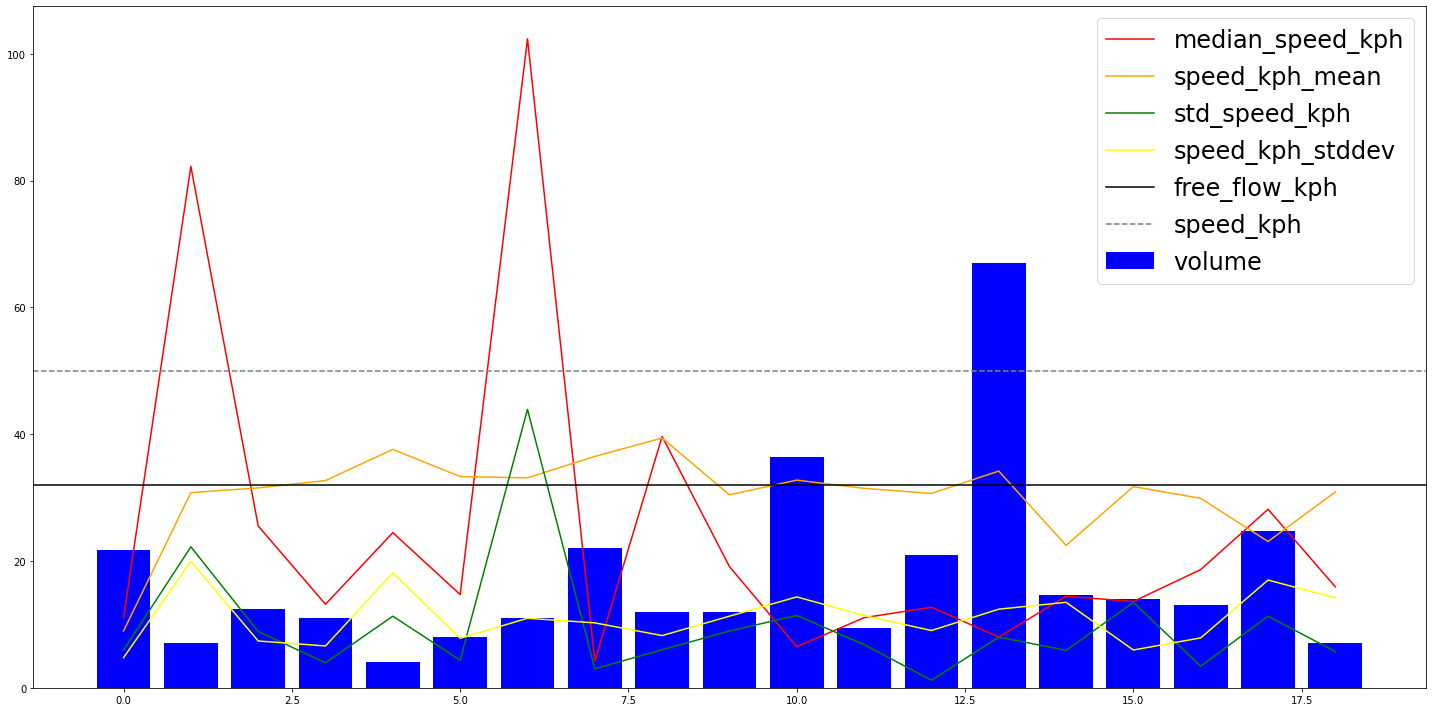

In [49]:
visualize_extreme_case(0)

year                                       2020.0
month                                         2.0
day                                          15.5
hour                                         14.5
speed_diff                              27.194559
std_speed_kph                           19.176471
median_speed_kph                        47.647059
speed_kph_mean                            20.4525
free_flow_kph                           38.588235
speed_kph                                    50.0
length_meters                           95.553666
x_u                                      2.166125
y_u                                     41.376407
x_v                                      2.165433
y_v                                     41.376917
name                            Ronda de Sant Pau
count                                           2
u                                      3865315674
v                                        30246674
gkey                3865315674_30246674_601740758


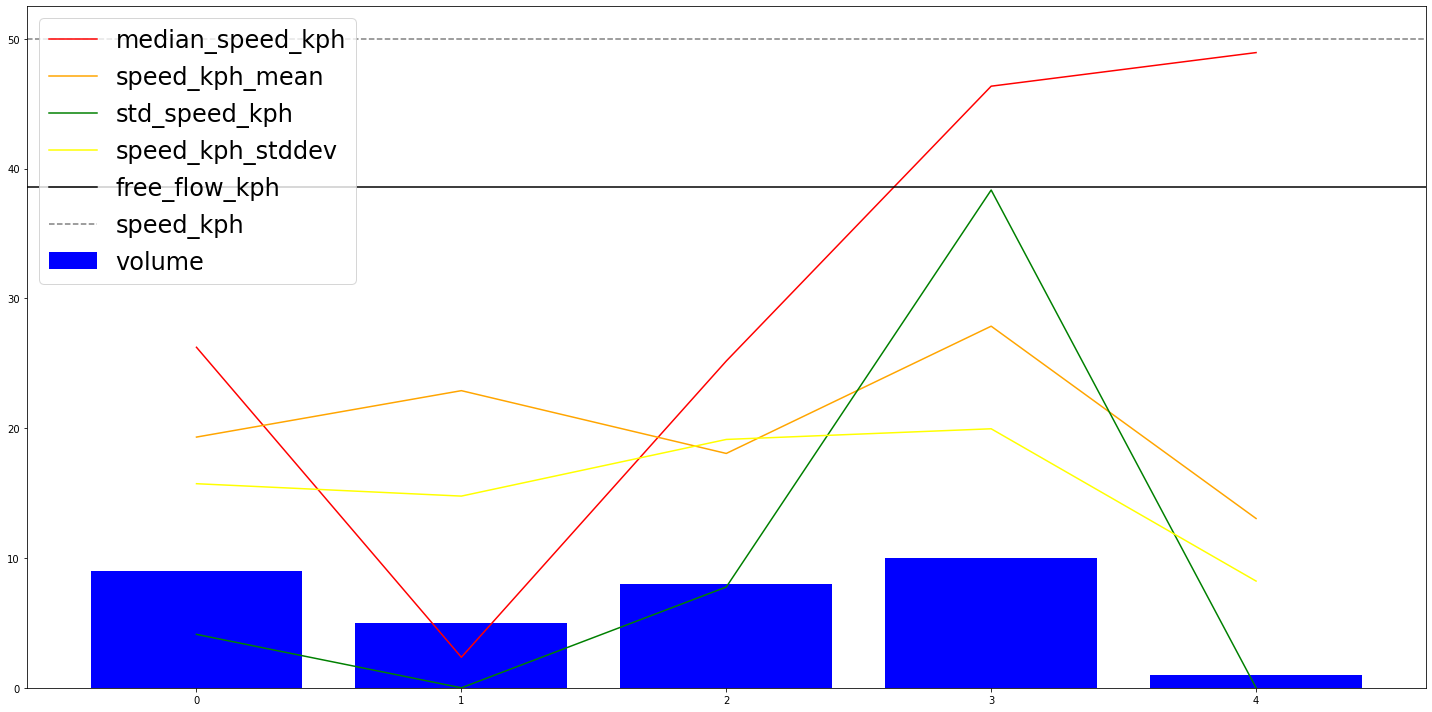

In [50]:
visualize_extreme_case(55)

year                                         2020.0
month                                           2.0
day                                             7.0
hour                                           14.0
speed_diff                                21.127098
std_speed_kph                             17.757777
median_speed_kph                          40.745098
speed_kph_mean                               19.618
free_flow_kph                                  32.0
speed_kph                                      50.0
length_meters                             50.599515
x_u                                        2.144427
y_u                                       41.393097
x_v                                         2.14404
y_v                                       41.392858
name                        Plaça de Francesc Macià
count                                             2
u                                        1840720990
v                                        5241929669
gkey        

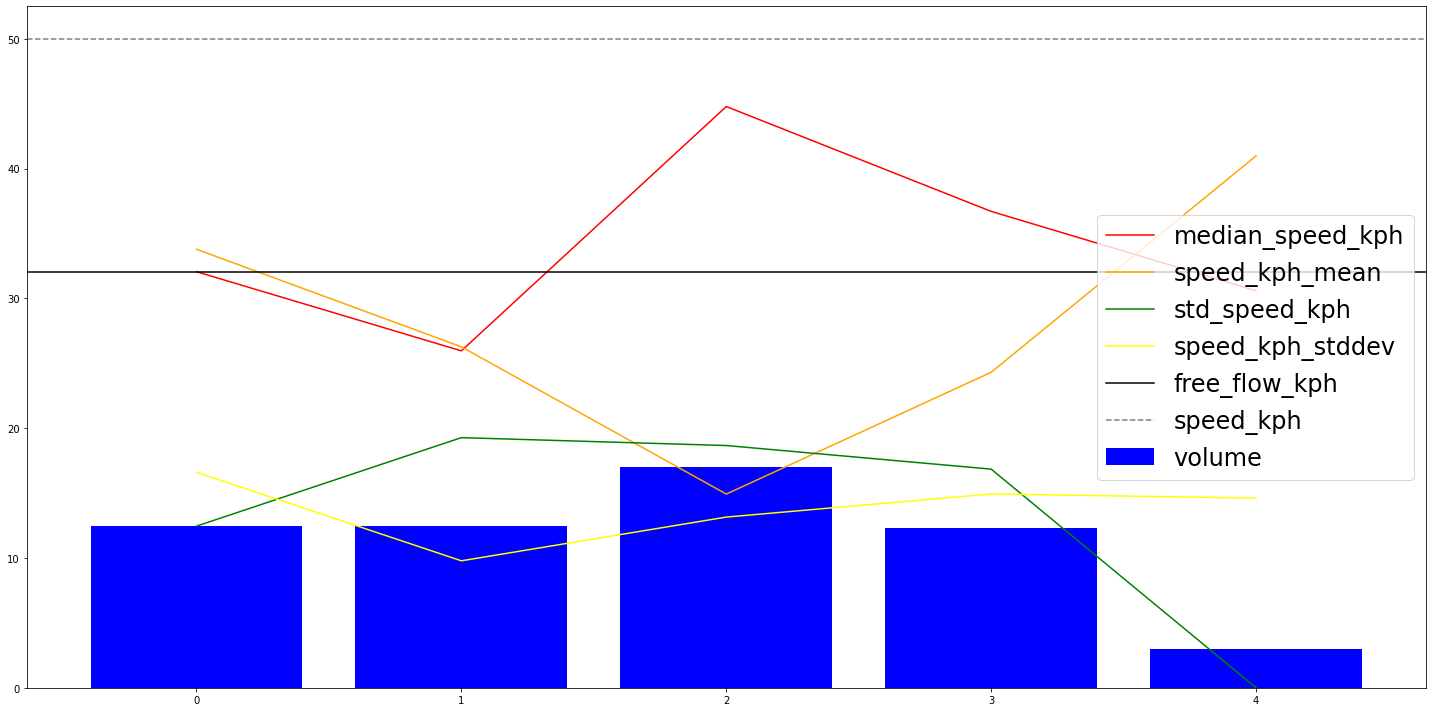

In [51]:
visualize_extreme_case(105)

year                                        2020.0
month                                          2.0
day                                           20.5
hour                                          14.0
speed_diff                               54.606147
std_speed_kph                                  0.0
median_speed_kph                         84.117647
speed_kph_mean                             29.5115
free_flow_kph                            28.235294
speed_kph                                     49.7
length_meters                            19.221768
x_u                                       2.171325
y_u                                      41.391264
x_v                                       2.171189
y_v                                      41.391371
name                     Carrer de Roger de Llúria
count                                            2
u                                       5268554951
v                                        559787232
gkey                5268554951_

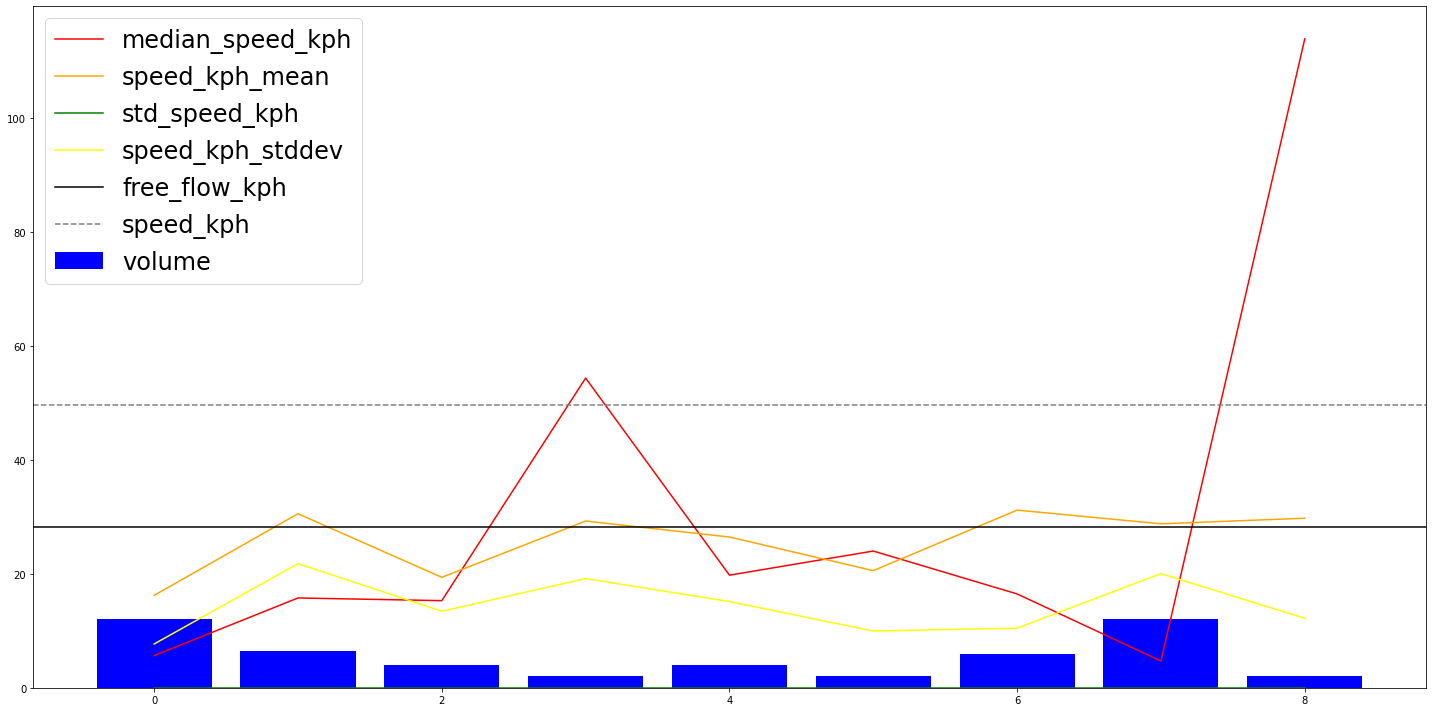

In [52]:
visualize_extreme_case(3)

year                                         2020.0
month                                           2.0
day                                            17.5
hour                                           15.0
speed_diff                                50.863206
std_speed_kph                             18.261386
median_speed_kph                          71.764706
speed_kph_mean                              20.9015
free_flow_kph                             35.764706
speed_kph                                      50.0
length_meters                             47.737504
x_u                                         2.16507
y_u                                         41.3861
x_v                                        2.164667
y_v                                       41.385953
name                        Ronda de la Universitat
count                                             2
u                                        2495598149
v                                        3218700096
gkey        

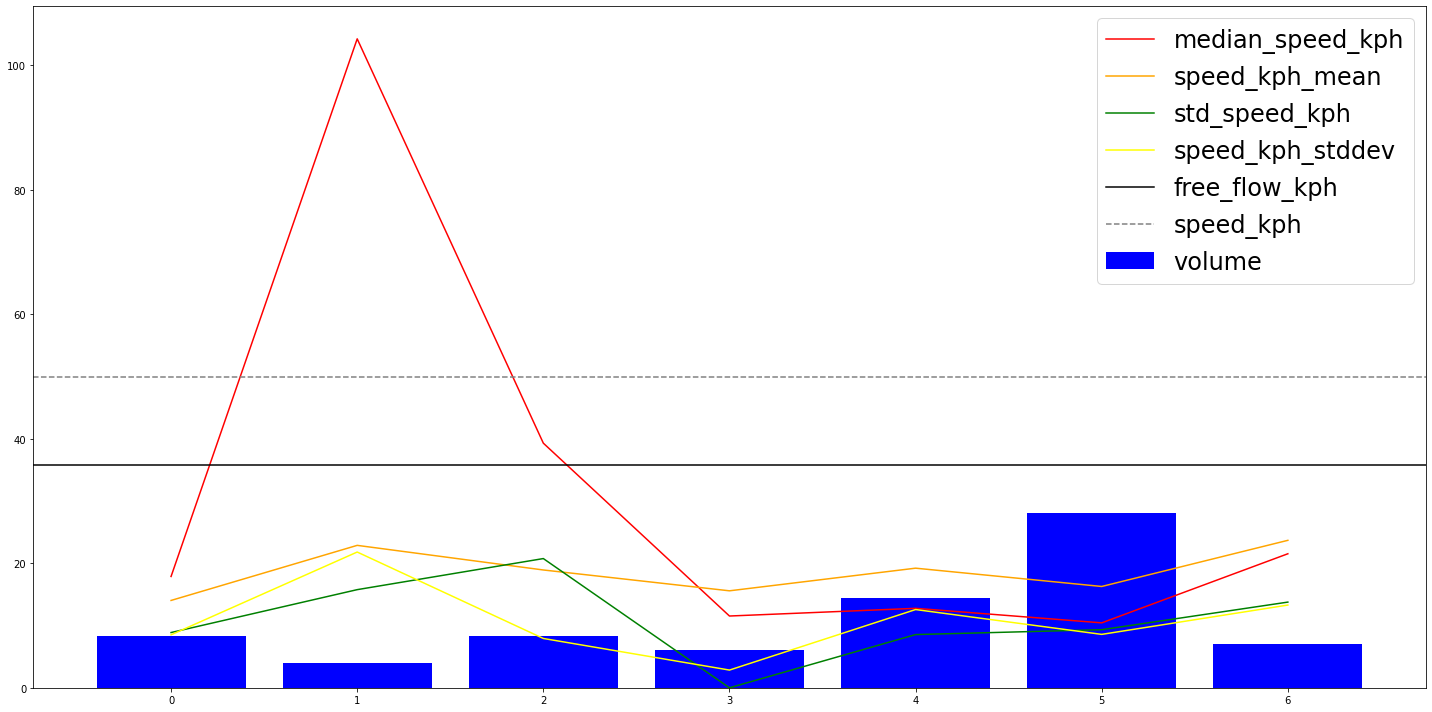

In [53]:
visualize_extreme_case(4)

year                                        2020.0
month                                          2.0
day                                           16.0
hour                                          13.5
speed_diff                               50.678029
std_speed_kph                                  0.0
median_speed_kph                         82.823529
speed_kph_mean                             32.1455
free_flow_kph                            30.588235
speed_kph                                     50.0
length_meters                            44.865577
x_u                                       2.135096
y_u                                      41.375407
x_v                                       2.135499
y_v                                      41.375399
name                               Carrer de Sants
count                                            2
u                                        539147476
v                                       2692588225
gkey                539147476_2

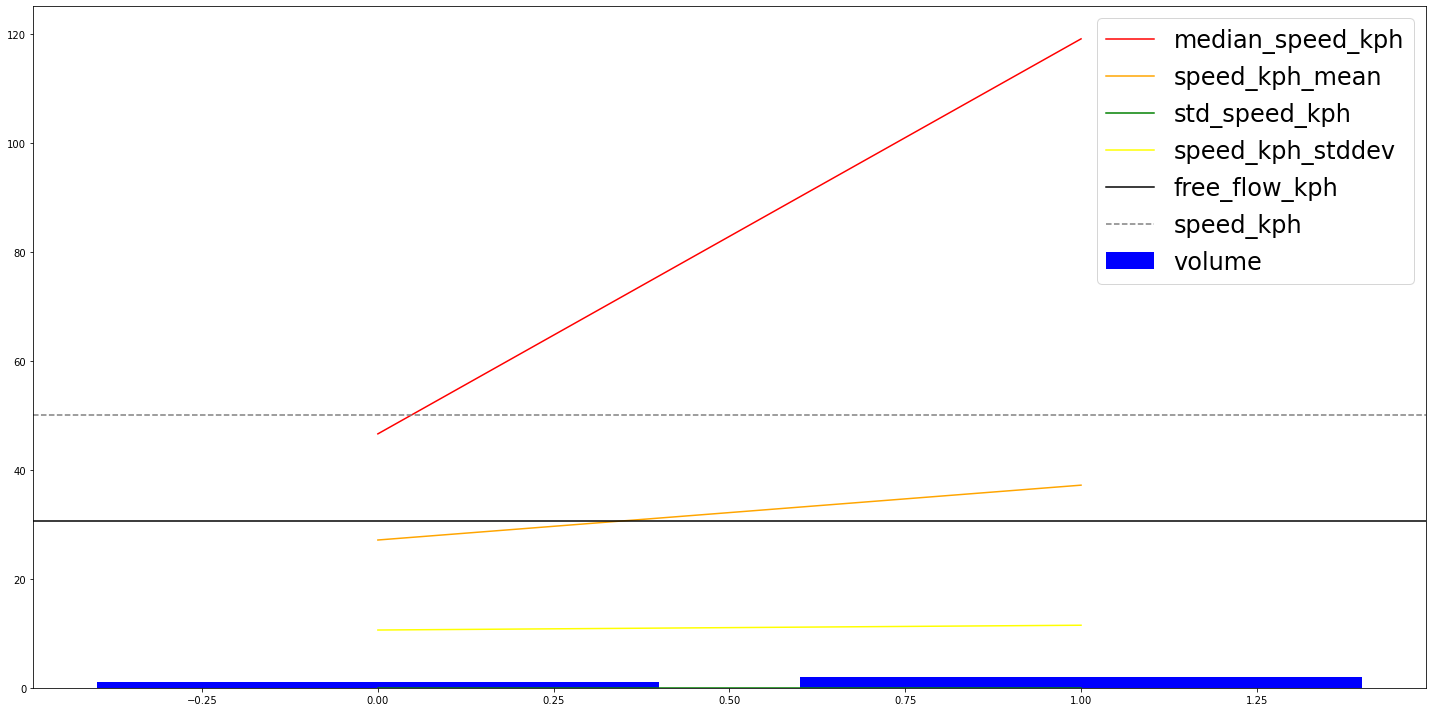

In [54]:
visualize_extreme_case(5)

year                                         2020.0
month                                           2.0
day                                            14.0
hour                                           14.0
speed_diff                                40.175853
std_speed_kph                                   0.0
median_speed_kph                          73.882353
speed_kph_mean                              33.7065
free_flow_kph                             24.235294
speed_kph                                      49.5
length_meters                             10.157239
x_u                                        2.148677
y_u                                       41.395558
x_v                                        2.148754
y_v                                       41.395608
name                           Travessera de Gràcia
count                                             2
u                                        3434285993
v                                        5249411001
gkey        

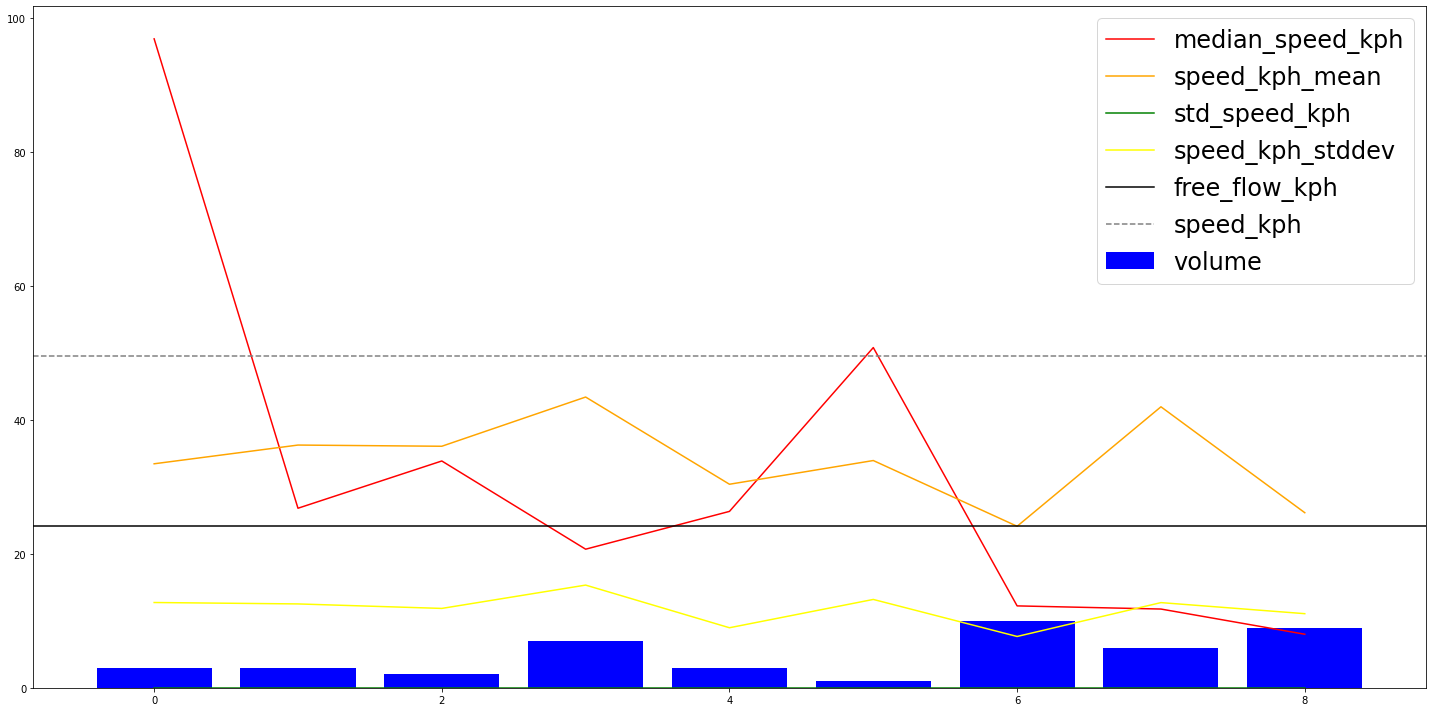

In [55]:
visualize_extreme_case(15)

## Inspect extreme cases (speed_diff < -10 and median_speed_kph < 15)

In [56]:
cols = [
    "year",
    "month",
    "day",
    "hour",
    "speed_diff",
    "std_speed_kph",
    "median_speed_kph",
    "speed_kph_mean",
    "free_flow_kph",
    "speed_kph",
    "length_meters",
    "x_u",
    "y_u",
    "x_v",
    "y_v",
]

extreme_edges_low = (
    ut_merged[(ut_merged["speed_diff"] < -10) & (ut_merged["median_speed_kph"] < 15)]
    .groupby(["u", "v", "gkey"])
    .agg(**{col: (col, "mean") for col in cols}, count=("year", "count"), name=("name", "first"), highway=("highway", "first"))
    .reset_index()[cols + ["name", "count", "u", "v", "gkey", "highway"]]
    .sort_values("speed_diff", ascending=True)
)
extreme_edges_low = extreme_edges_low[extreme_edges_low["count"] > 1]
extreme_edges_low

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,...,x_u,y_u,x_v,y_v,name,count,u,v,gkey,highway
477,2020.0,2.0,12.333333,13.333333,-37.656314,0.000000,8.549020,46.205333,42.823529,50.0,...,2.168392,41.391749,2.168612,41.391582,Carrer de Pau Claris,3,5484707798,30243054,5484707798_30243054_449991630,secondary
214,2020.0,2.0,15.000000,14.500000,-36.636088,0.000000,8.529412,45.165500,34.117647,50.0,...,2.176581,41.385580,2.176948,41.385305,Via Laietana,2,234836631,234834329,234836631_234834329_423231443,secondary
11,2020.0,2.0,9.000000,15.666667,-36.499020,8.885905,10.784314,47.283333,32.941176,50.0,...,2.178734,41.383960,2.179307,41.383526,Via Laietana,3,30227495,6070339664,30227495_6070339664_423232178,secondary
453,2020.0,2.0,8.500000,14.500000,-36.156118,0.588235,6.705882,42.862000,32.000000,50.0,...,2.151703,41.400036,2.151684,41.400160,Via Augusta,2,5227213296,2087205009,5227213296_2087205009_540281992,secondary
358,2020.0,2.0,9.000000,14.000000,-35.804706,0.000000,4.235294,40.040000,33.882353,50.0,...,2.151448,41.400362,2.151287,41.400474,Via Augusta,2,1457780093,1457780310,1457780093_1457780310_251699041,secondary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020.0,2.0,12.500000,14.000000,-11.828824,6.301545,12.941176,24.770000,39.529412,49.7,...,2.169231,41.392849,2.168637,41.393299,Carrer de Roger de Llúria,2,1473221664,30242866,1473221664_30242866_449991634,secondary
132,2020.0,2.0,12.000000,13.500000,-11.768088,0.000000,7.529412,19.297500,21.647059,30.0,...,2.144083,41.394955,2.143549,41.394642,Carrer de Marià Cubí,2,30313123,30313144,30313123_30313144_4752018,residential
183,2020.0,2.0,11.333333,13.000000,-10.713150,0.366013,7.790850,18.504000,20.705882,49.5,...,2.152334,41.403074,2.151934,41.403927,Carrer Gran de Gràcia,3,60969503,60969502,60969503_60969502_296827111,tertiary
451,2020.0,2.0,18.000000,13.500000,-10.511598,0.000000,10.254902,20.766500,13.647059,50.0,...,2.165347,41.386203,2.165070,41.386100,Ronda de la Universitat,2,5168258284,2495598149,5168258284_2495598149_532631875,secondary


year                                       2020.0
month                                         2.0
day                                     12.333333
hour                                    13.333333
speed_diff                             -37.656314
std_speed_kph                                 0.0
median_speed_kph                          8.54902
speed_kph_mean                          46.205333
free_flow_kph                           42.823529
speed_kph                                    50.0
length_meters                           30.704559
x_u                                      2.168392
y_u                                     41.391749
x_v                                      2.168612
y_v                                     41.391582
name                         Carrer de Pau Claris
count                                           3
u                                      5484707798
v                                        30243054
gkey                5484707798_30243054_449991630


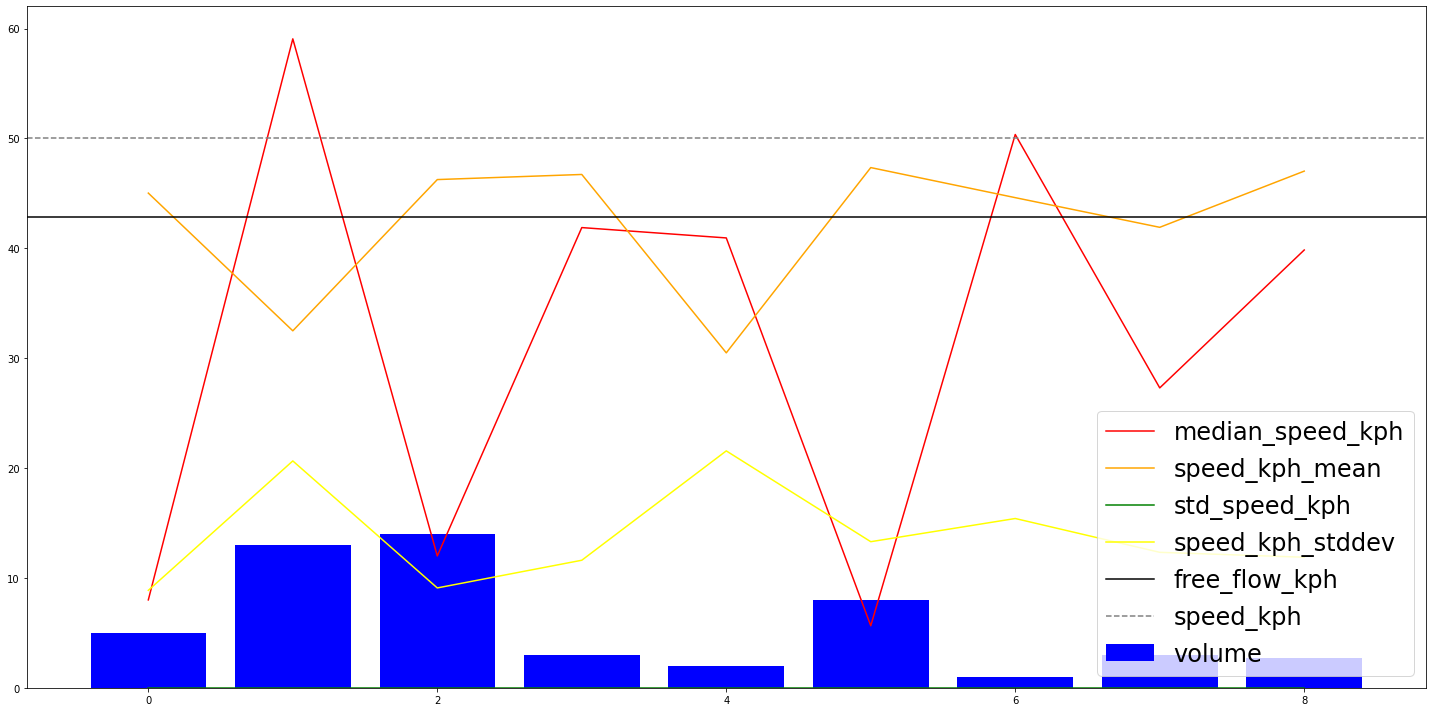

In [57]:
visualize_extreme_case(0, extreme_edges_low)

year                                       2020.0
month                                         2.0
day                                          15.0
hour                                         14.5
speed_diff                             -36.636088
std_speed_kph                                 0.0
median_speed_kph                         8.529412
speed_kph_mean                            45.1655
free_flow_kph                           34.117647
speed_kph                                    50.0
length_meters                           51.012052
x_u                                      2.176581
y_u                                      41.38558
x_v                                      2.176948
y_v                                     41.385305
name                                 Via Laietana
count                                           2
u                                       234836631
v                                       234834329
gkey                234836631_234834329_423231443


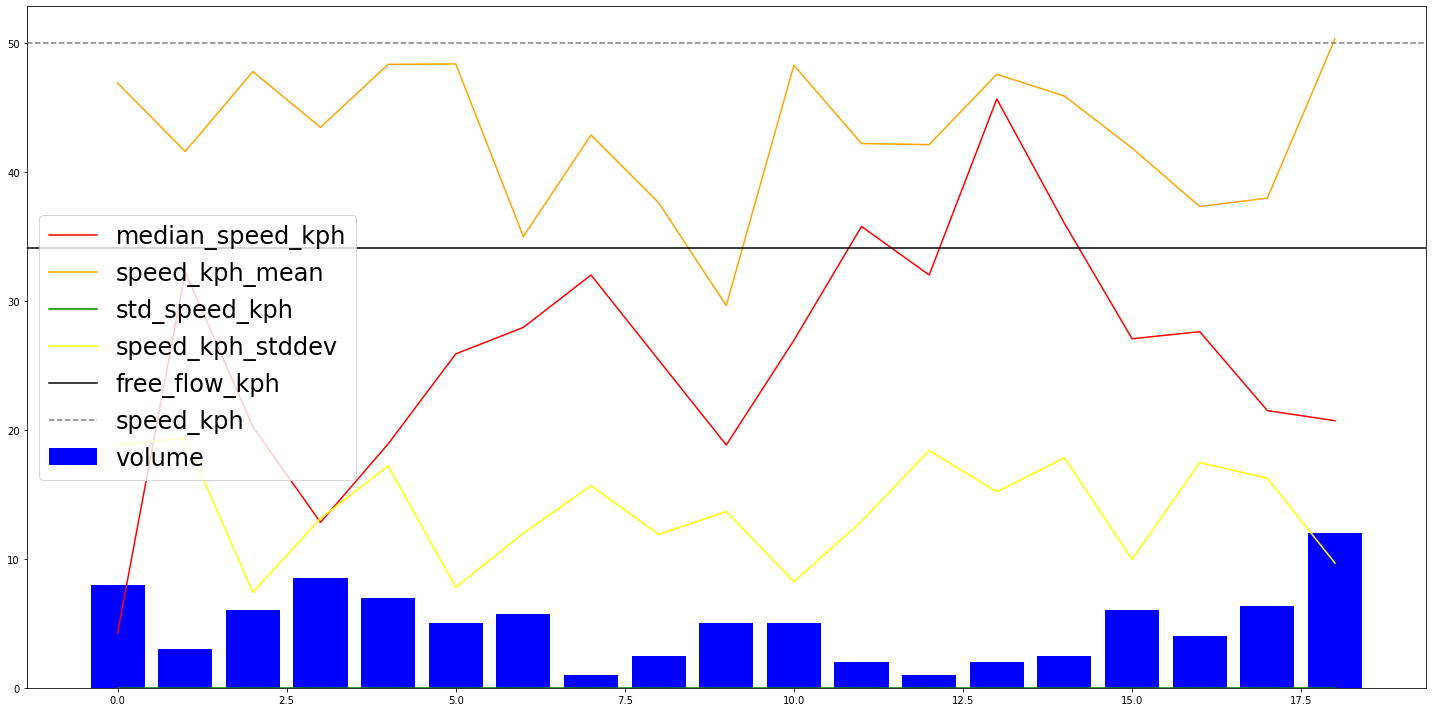

In [58]:
visualize_extreme_case(1, extreme_edges_low)

year                                       2020.0
month                                         2.0
day                                           9.0
hour                                    15.666667
speed_diff                              -36.49902
std_speed_kph                            8.885905
median_speed_kph                        10.784314
speed_kph_mean                          47.283333
free_flow_kph                           32.941176
speed_kph                                    50.0
length_meters                           79.913562
x_u                                      2.178734
y_u                                      41.38396
x_v                                      2.179307
y_v                                     41.383526
name                                 Via Laietana
count                                           3
u                                        30227495
v                                      6070339664
gkey                30227495_6070339664_423232178


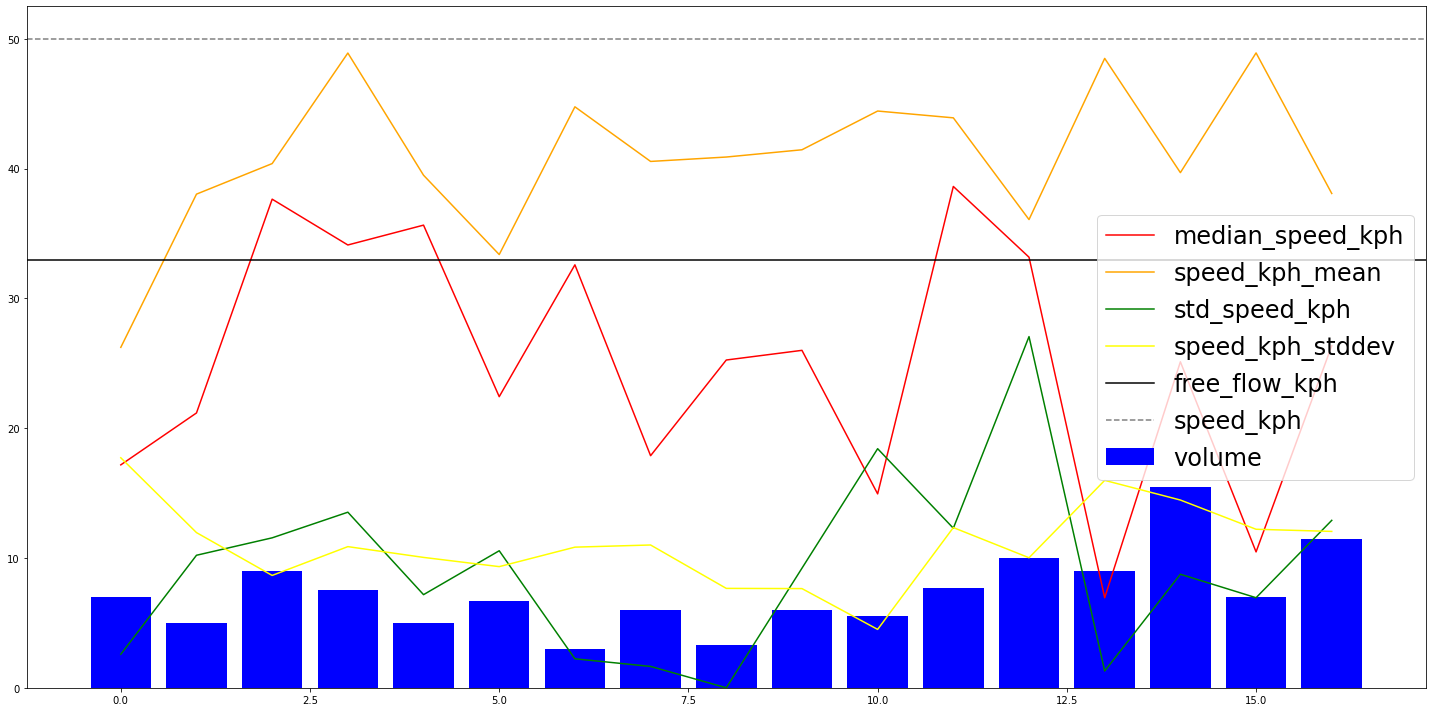

In [59]:
visualize_extreme_case(2, extreme_edges_low)

year                                      2020.0
month                                        2.0
day                                         15.8
hour                                        14.4
speed_diff                            -24.812847
std_speed_kph                           2.864689
median_speed_kph                        8.282353
speed_kph_mean                           33.0952
free_flow_kph                          37.647059
speed_kph                                   50.0
length_meters                         103.951177
x_u                                      2.16554
y_u                                    41.387115
x_v                                     2.166292
y_v                                    41.386559
name                            Carrer de Balmes
count                                          5
u                                      559765972
v                                       26057304
gkey                559765972_26057304_237522641
highway             

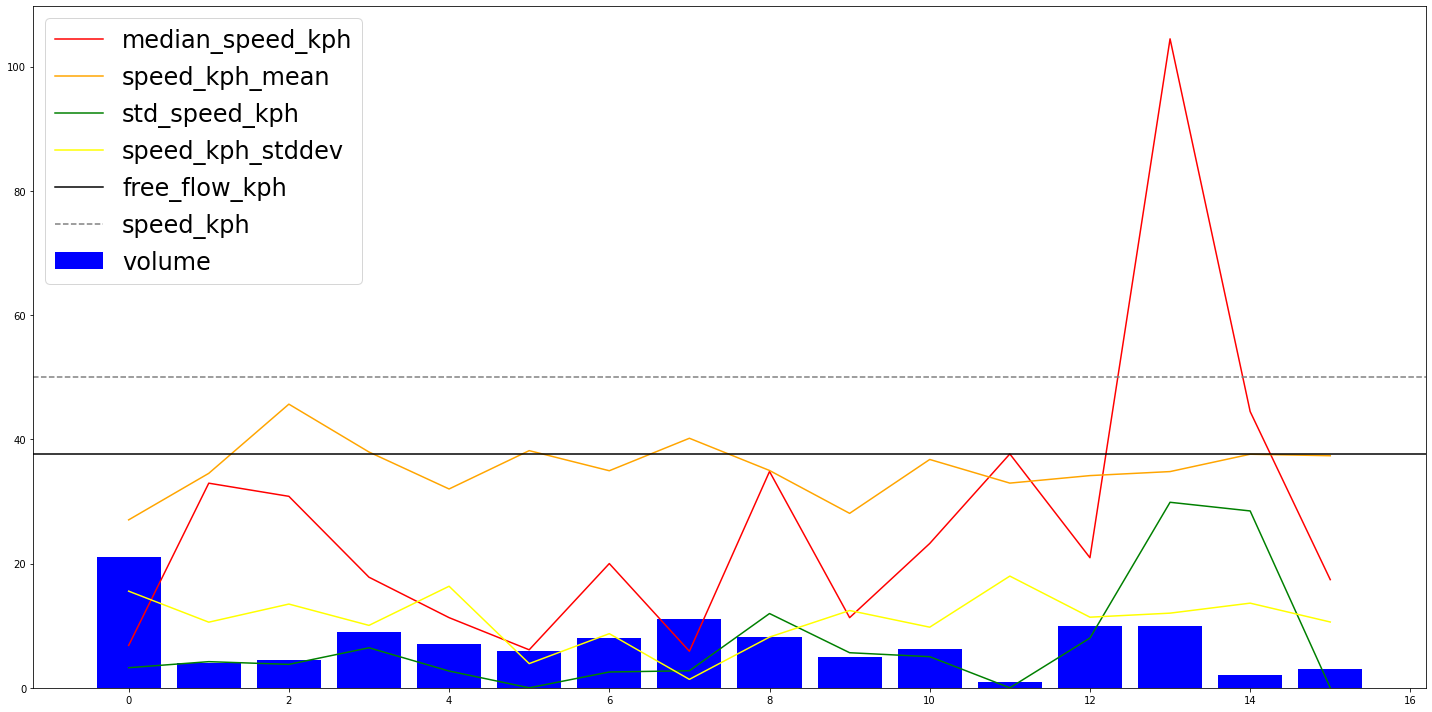

In [60]:
visualize_extreme_case(55, extreme_edges_low)

year                                      2020.0
month                                        2.0
day                                    12.333333
hour                                   14.333333
speed_diff                               -15.716
std_speed_kph                                0.0
median_speed_kph                        5.333333
speed_kph_mean                         21.049333
free_flow_kph                          15.058824
speed_kph                                   49.5
length_meters                          29.685656
x_u                                      2.16015
y_u                                    41.402784
x_v                                     2.160378
y_v                                    41.402924
name                        Travessera de Gràcia
count                                          3
u                                       30555746
v                                      126699971
gkey                30555746_126699971_237659862
highway             

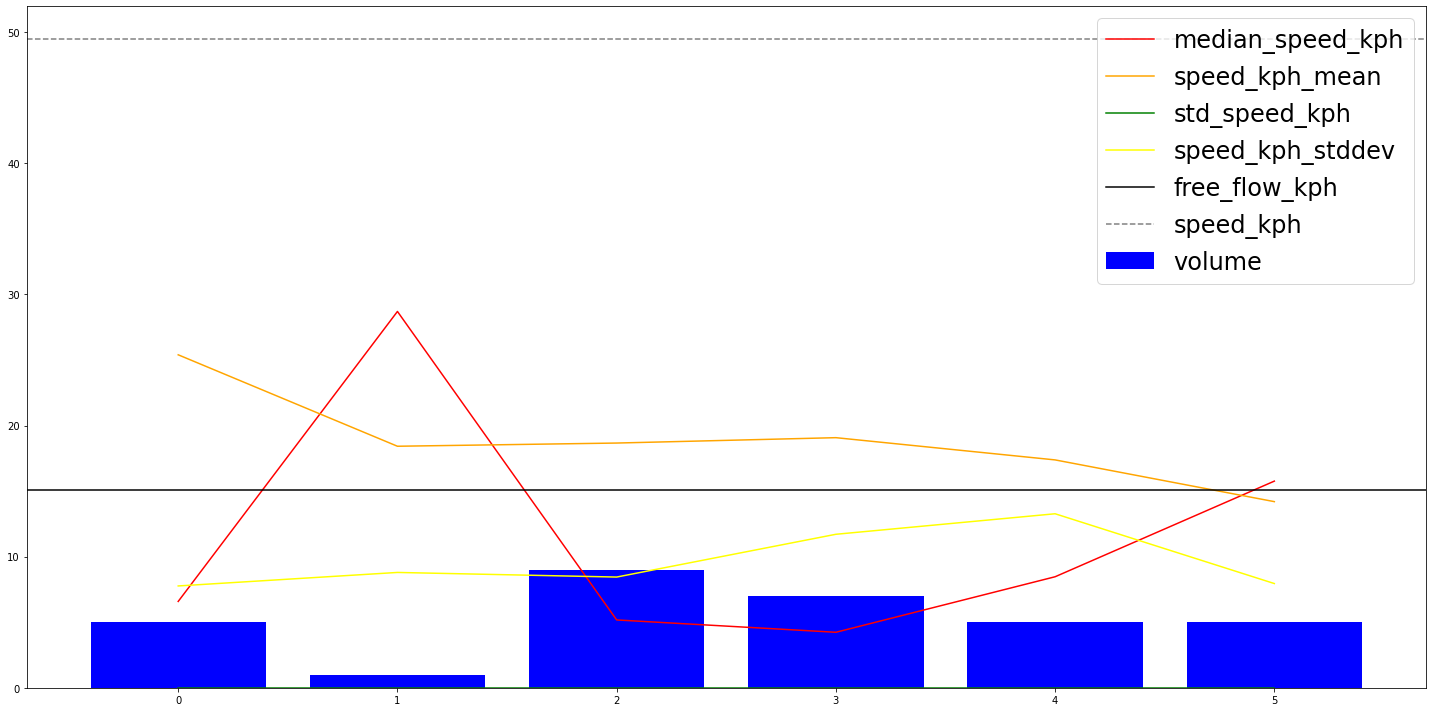

In [61]:
visualize_extreme_case(157, extreme_edges_low)

year                                      2020.0
month                                        2.0
day                                     9.833333
hour                                        14.0
speed_diff                            -15.900088
std_speed_kph                           1.431373
median_speed_kph                        7.196078
speed_kph_mean                         23.096167
free_flow_kph                               32.0
speed_kph                                   49.5
length_meters                          85.641377
x_u                                     2.150631
y_u                                    41.405544
x_v                                      2.15006
y_v                                    41.406061
name                       Carrer Gran de Gràcia
count                                          6
u                                       30295094
v                                      359097332
gkey                30295094_359097332_238466746
highway             

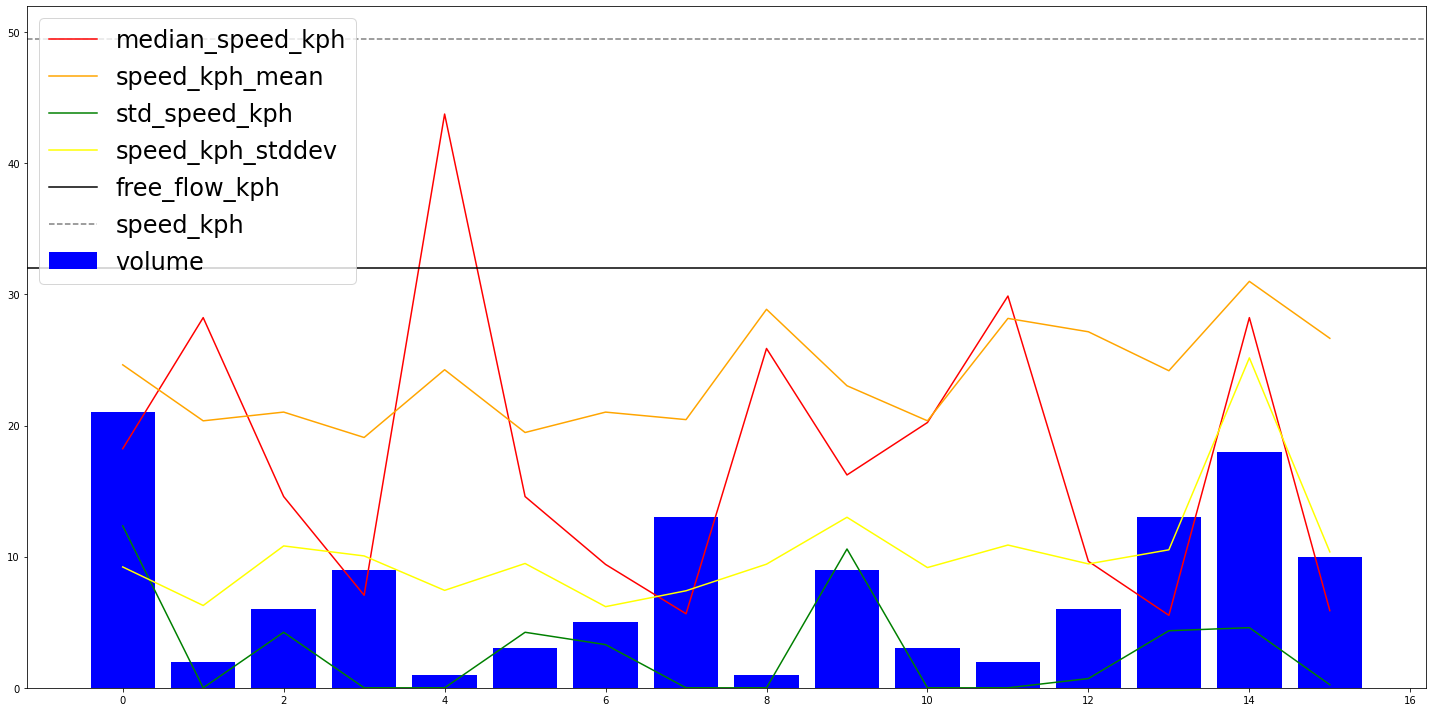

In [62]:
visualize_extreme_case(150, extreme_edges_low)

In [63]:
extreme_edges_low.groupby("highway").count()

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,name,count,u,v,gkey
highway,,,,,,,,,,,,,,,,,,,,
primary,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
primary_link,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
residential,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
secondary,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98
secondary_link,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
tertiary,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
tertiary_link,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [64]:
extreme_edges_low.groupby("highway").median()

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,count,u,v
highway,,,,,,,,,,,,,,,,,,
primary,2020.0,2.0,16.000000,14.5,-22.018029,3.173486,9.176471,31.194500,38.823529,50.0,49.515606,2.148209,41.389839,2.148029,41.390116,2.0,2.189602e+09,4.578875e+08
primary_link,2020.0,2.0,13.000000,14.0,-29.057444,0.026144,8.303922,35.946333,49.882353,50.0,41.380323,2.149601,41.406692,2.149904,41.406960,4.0,4.159503e+08,4.159503e+08
residential,2020.0,2.0,14.000000,14.0,-21.081794,1.333333,7.392157,28.102500,21.647059,30.0,67.620541,2.159597,41.400021,2.159597,41.399918,2.0,3.055675e+07,3.055675e+07
secondary,2020.0,2.0,14.166667,14.0,-22.913912,1.605341,9.443900,32.334000,33.647059,50.0,53.908380,2.166556,41.391476,2.166373,41.391403,2.0,4.425403e+08,2.163503e+08
secondary_link,2020.0,2.0,14.400000,14.4,-24.555669,7.597537,12.460131,37.015800,32.470588,50.0,43.096485,2.173742,41.388956,2.173749,41.389344,5.0,2.605735e+07,2.605734e+07
tertiary,2020.0,2.0,13.000000,14.0,-19.435892,1.133760,7.294118,27.767875,28.235294,49.5,70.966060,2.153060,41.398366,2.153099,41.398654,3.0,6.096950e+07,6.096949e+07
tertiary_link,2020.0,2.0,15.000000,13.5,-23.916059,0.000000,9.274510,31.188500,33.411765,50.0,13.713003,2.159672,41.396475,2.159707,41.396534,2.0,1.311620e+09,1.311620e+09


In [65]:
extreme_edges_low.groupby("highway").max()

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,name,count,u,v,gkey
highway,,,,,,,,,,,,,,,,,,,,
primary,2020.0,2.0,19.500000,14.500000,-13.229520,10.363203,12.852941,36.324000,44.000000,50.0,197.469065,2.177263,41.427763,2.177299,41.428194,Ronda del General Mitre,2,5256357720,6210812030,998637904_6210812030_237549914
primary_link,2020.0,2.0,14.666667,14.500000,-23.779730,6.492403,9.549020,38.314750,49.882353,50.0,44.950581,2.149904,41.406960,2.149954,41.407329,Plaça de Lesseps,4,5249411005,5249411005,5249411005_415950287_237652086
residential,2020.0,2.0,20.000000,14.666667,-11.768088,6.256970,12.117647,43.319000,43.294118,38.6,165.991783,2.186299,41.439750,2.186283,41.439847,Passeig de Gràcia,6,4703847659,4703847659,506236275_30242768_238179162
secondary,2020.0,2.0,20.000000,15.666667,-10.300500,11.689090,14.558824,47.283333,42.941176,50.0,378.022624,2.195465,41.419313,2.195501,41.419413,Via Laietana,8,6395340810,6395340810,879356690_4436976528_238179161
secondary_link,2020.0,2.0,14.400000,14.400000,-24.555669,7.597537,12.460131,37.015800,32.470588,50.0,43.096485,2.173742,41.388956,2.173749,41.389344,Plaça d'Urquinaona,5,26057347,26057341,26057347_26057341_237725954
tertiary,2020.0,2.0,17.200000,15.428571,-10.713150,10.483760,13.705882,40.890500,44.705882,50.0,222.422358,2.172912,41.406255,2.173303,41.406554,Travessera de Gràcia,8,5249411001,5249411001,82026109_60969463_32015691
tertiary_link,2020.0,2.0,21.000000,14.500000,-17.343412,5.393404,11.647059,40.195000,37.647059,50.0,202.001226,2.170140,41.399069,2.170153,41.399098,Plaça del Cinc d'Oros,6,1311770049,1311770049,344992888_30254222_237660551


In [66]:
extreme_edges_low[extreme_edges_low["length_meters"] > 150]

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,...,x_u,y_u,x_v,y_v,name,count,u,v,gkey,highway
101,2020.0,2.0,18.000000,13.500000,-30.466206,0.823529,10.235294,40.701500,40.470588,49.7,...,2.175498,41.406963,2.176616,41.407797,Carrer del Rosselló,2,30253571,30253572,30253571_30253572_68506248,secondary
34,2020.0,2.0,16.000000,15.000000,-29.690118,10.483760,9.705882,39.396000,35.764706,49.5,...,2.162098,41.382890,2.160963,41.382038,Carrer de Sepúlveda,2,30238011,30243883,30238011_30243883_12373020,tertiary
14,2020.0,2.0,18.500000,13.500000,-27.030500,5.381828,11.750000,38.780500,38.117647,50.0,...,2.155109,41.395015,2.156232,41.394168,Carrer de Balmes,2,30237617,30247432,30237617_30247432_238866888,secondary
436,2020.0,2.0,15.500000,14.500000,-25.655912,1.069661,8.470588,34.126500,38.352941,50.0,...,2.163195,41.375038,2.160920,41.375052,Avinguda del Paral·lel,2,4538123416,4538123412,4538123416_4538123412_601816556,secondary
277,2020.0,2.0,14.500000,14.500000,-25.609333,3.548011,8.666667,34.276000,35.764706,38.6,...,2.183727,41.399113,2.184898,41.398187,Carrer de Lepant,2,506236275,30242768,506236275_30242768_238179162,residential
104,2020.0,2.0,14.000000,15.500000,-25.301588,1.418177,10.529412,35.831000,33.882353,49.7,...,2.177719,41.408602,2.178867,41.409435,Carrer del Rosselló,2,30253573,30253574,30253573_30253574_518534109,secondary
306,2020.0,2.0,15.333333,14.333333,-24.992608,5.516523,8.647059,33.639667,32.000000,50.0,...,2.160966,41.380338,2.159832,41.381198,Carrer del Comte d'Urgell,3,1043786431,2326000392,1043786431_2326000392_237655878,secondary
174,2020.0,2.0,18.500000,13.500000,-24.784206,7.844551,12.235294,37.019500,41.882353,49.7,...,2.167514,41.394149,2.166390,41.394998,Carrer de Roger de Llúria,2,33098963,30243328,33098963_30243328_449991634,secondary
13,2020.0,2.0,15.000000,14.166667,-24.608147,5.959003,12.215686,36.823833,29.647059,50.0,...,2.151714,41.392448,2.152820,41.391631,Carrer de Muntaner,6,30237614,30237696,30237614_30237696_243716769,secondary
50,2020.0,2.0,16.000000,13.500000,-24.377294,3.235294,6.764706,31.142000,42.823529,50.0,...,2.168612,41.391582,2.169714,41.390746,Carrer de Pau Claris,2,30243054,559787230,30243054_559787230_449991630,secondary
